In [1]:
##### Reading mouse information from xlsx file #####
# import pandas as pd
# import numpy as np

# xlsxFile = '/home/eunjung/HwangLab/Subjects/CSVdata/2025AgingMice.xlsx'
# specific_sheets_names = ['AllMice']
# AllMiceDF = pd.read_excel(xlsxFile, sheet_name=specific_sheets_names)['AllMice']
# AllMiceDF['First Day Training'] = AllMiceDF['First Day Training'].dt.strftime('%Y-%m-%d')
# AllMice = AllMiceDF.to_dict(orient='list')


# SubjectDB = {}
# for key in ['name', 'age_months', 'experiment', 'sex', 'genotype', 'First Day Training']:    
#     SubjectDB[key] = np.array(AllMice[key])
    
# np.save('2025Nature_SubjectDB.npy', SubjectDB)

# Analysis and Plot Functions
Run this block before executing figure plotting cells.

In [201]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import DataCrunch as Hwang
from iblutil.util import Bunch
import one.alf.io as aio
import brainbox.behavior.training as ReadAlyx
import pandas as pd
import scipy.stats as stats
import itertools
import statsmodels.api as sm
import scipy.optimize as opt
from scipy.stats.distributions import chi2
from statsmodels.stats.multitest import multipletests
from one.api import ONE
one = ONE()

def combine_criteria(min_age, max_age, keys, key_values):
##### combine subject group criteris including minimum and maximum ages
##### e.g., criteria = combine_criteria(2, 3, ['line'], ['WT']) to create a group of wild-type, 2-3 months old mice 
    criteria = {}
    group_name = str(min_age)+'-'+str(max_age)+' mo'
    for key_value in key_values:
        group_name = group_name + '-'+ key_value
    criteria['group_name']  = group_name
    criteria['min_age'] = min_age
    criteria['max_age'] = max_age
    for key, key_value in zip(keys, key_values):
        criteria[key] = key_value
    return criteria

def group_subjects(group_criteria, SubjectDB):
##### select subjects in SubjectDB that meet group_criteria
    subject_lists = []
    group_names = []
    ages = []
    sexes = []
    dates = []
    for group in group_criteria:
        group_names.append(group['group_name'])
        subject_indices = np.flatnonzero((SubjectDB['age_months']>=group['min_age'])*(SubjectDB['age_months']<group['max_age']))
        for key in group.keys():
            if not key in ['group_name', 'min_age', 'max_age']:
                subject_indices = np.intersect1d(subject_indices,np.flatnonzero(SubjectDB[key]==group[key]))
        subject_lists.append(SubjectDB['name'][subject_indices])
        ages.append(SubjectDB['age_months'][subject_indices])
        sexes.append((SubjectDB['sex'][subject_indices]=='Female')*1)
        dates.append(SubjectDB['First Day Training'][subject_indices])
    return subject_lists, group_names, ages, sexes, dates

def set_rcParams():
##### set global plot parameters
    plt.rcParams['svg.fonttype'] = 'none' # do not convert text to path
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.size'] = 6.5
    plt.rcParams['font.stretch'] = 'normal'
    
def set_plot(axe):
##### remove the top and right axis lines
    axe.spines['top'].set_visible(False)
    axe.spines['right'].set_visible(False)


def postHoc_mutipleComparisons(groups, method='fdr_bh'):
### multiple comparison methods: 'bonferroni', 'fdr_bh': Benhamini-Hochberg
    # Kruskal-Wallis H-test
    h_stat, p_val = stats.kruskal(*groups.values())
    print(f"Kruskal-Wallis H-test: H = {h_stat:.3f}, p = {p_val:.3f}")

    # Pairwise Mann-Whitney U tests for post hoc analysis
    comparisons = list(itertools.combinations(groups.keys(), 2))
    p_values = []

    print("\nPairwise Mann–Whitney U tests:")
    for g1, g2 in comparisons:
        stat, p = stats.mannwhitneyu(groups[g1], groups[g2], alternative='two-sided')        
        p_values.append(p)
        n1 = len(groups[g1])
        n2 = len(groups[g2])
        rank = n1*(n1+1)/2
        print(f"{g1} vs {g2}: W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")

    corrected = multipletests(p_values, method=method)
    print("\ncorrected p-values:")
    for (g1, g2), p_corr in zip(comparisons, corrected[1]):
        print(f"{g1} vs {g2}: corrected p = {p_corr:.3f}")

def FullContrastPerf_trials(sessions):
    y = []
    for session in sessions:
        td = read_trial_data(one.eid2path(session['url']))
        inds = np.flatnonzero((td['contrastLeft']==1)+(td['contrastRight']==1)) #select 100% contrast trials
        y = td['feedbackType'][inds] if len(y)==0 else np.hstack((y,td['feedbackType'][inds]))
    y = (y+1)/2 #transform feedback to 0 (error) or 1 (reward)
    return box_smooth(y,300)


def box_smooth(x, period):
    y = np.full_like(x,np.nan)
    half_period = int(period/2)
    if len(x.shape)==1:
        padded_array = np.concatenate((np.concatenate((np.ones(half_period-1)*x[0],x)), np.ones(half_period)*x[-1]))        
        z = np.convolve(padded_array, np.ones(period)/period, mode='valid')
        y = z
    else:
        for i in range(len(x.shape)):
            padded_array = np.concatenate((np.ones(period-2)*(np.nan),x[:,i]))
            padded_array = np.concatenate((np.concatenate((np.ones(half_period)*x[0,i],x[:,i])), np.ones(half_period-1)*x[-1,i]))
            z = np.convolve(padded_array, np.ones(period)/period, mode='valid')
            y[:,i] = z
    return y

def PlotMean(subject_lists, MaxDay=30, figscale=0.2, colors=['red'], ylims=[0.3,1], legends=[]):    
    one = ONE()
        
    set_rcParams()    
    figure = plt.figure(figsize = [figscale*8,figscale*10])
    axe = plt.axes()       
    set_plot(axe)

    all_performance = []
    legend_text = []
    for i, subject_list in enumerate(subject_lists): 
        yaxis = np.full((len(subject_list),MaxDay), np.nan)
        for si, subject in enumerate(subject_list):
            sessions = sorted(one.alyx.rest('sessions', 'list', subject=subject, task_protocol='ChoiceWorld', qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
            y = FullContrastPerf(sessions)
            
            sub_days = min(len(y),MaxDay)
            
            yaxis[si][:sub_days] = y[:sub_days].flatten()
            
        all_performance.append(yaxis)
        legend_text.append(f'{legends[i]}(n={len(subject_list)})')

        plt.errorbar(np.arange(MaxDay)+1, np.nanmean(yaxis, axis=0), np.nanstd(yaxis, axis=0)/np.sqrt(len(subject_list)), color=colors[i], elinewidth=0.1, linewidth=0.8)

        plt.xlabel('Training day',fontsize=7)
        plt.ylabel('Correct choice rate', fontsize=7)

        plt.ylim(ylims[0], ylims[1])

        plt.xticks(np.arange(0,31,5))
        plt.legend(legend_text, fontsize=4.86, loc='upper left', bbox_to_anchor=(-0.2, 1.2), borderpad=0.1, labelspacing=0.2)
    return all_performance


def PlotMean_trials(subject_lists, MaxDay=30, figscale=0.2, colors=['red'], ylims=[0.3,1], legends=[]):    
    one = ONE()
        
    plt.rcParams['svg.fonttype'] = 'none' # do not convert text to path
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.size'] = 6.5
    
    
    figure = plt.figure(figsize = [figscale*8,figscale*10])
    axe = plt.axes()       
    axe.spines['top'].set_visible(False)
    axe.spines['right'].set_visible(False)
    all_perf = []
    legend_text = []
    NT=3000
    for i, subject_list in enumerate(subject_lists): 
        yaxis = np.full((len(subject_list), NT), np.nan)
        for si, subject in enumerate(subject_list):
            sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
            y = FullContrastPerf_trials(sessions)
            sub_day = min(NT, len(y))
            yaxis[si][:sub_day] = y[:sub_day]
            if sub_day<NT:
                yaxis[si][sub_day:] = y[sub_day-1]
            
        all_perf.append(yaxis)
        legend_text.append(f'{legends[i]}(n={len(subject_list)})')
        
        ms = np.nanmean(yaxis, axis=0)
        ss = np.nanstd(yaxis, axis=0)
        xx = np.arange(NT)+1
        t_inds = np.arange(150, NT, 300)

        plt.errorbar(xx[t_inds], ms[t_inds], ss[t_inds]/np.sqrt(len(subject_list)), color=colors[i], elinewidth=0.1, linewidth=1)

        plt.xlabel('Trial number',fontsize=7)
        plt.ylabel('Correct choice rate', fontsize=7)
        plt.ylim(ylims[0],ylims[-1])
        plt.xticks(np.arange(0,NT+1,1000))
        plt.legend(legend_text, fontsize=4.86, loc='upper left', bbox_to_anchor=(-0.2, 1.2), borderpad=0.1, labelspacing=0.2)
    return all_perf


def FullContrastPerf(sessions):
    y = []
    for session in sessions:
        #print(one.eid2path(session['url']))
        td = read_trial_data(one.eid2path(session['url']))
        inds = np.flatnonzero((td['contrastLeft']==1)+(td['contrastRight']==1))
        inds = np.intersect1d(inds, np.arange(200))
        if len(inds)>0:
            y.append(len(np.flatnonzero(td['feedbackType'][inds]==1))/len(inds))
        else:
            y.append(0)    
    return np.array(y)


def Get_timeInfo(subject_lists, MaxDay=30):    
    one = ONE()

    all_time = []
    for i, subject_list in enumerate(subject_lists): 
        yaxis = np.full((len(subject_list), MaxDay, 2), np.nan)
        for si, subject in enumerate(subject_list):
            sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
            for ss, session in enumerate(sessions[:MaxDay]):
                td = read_trial_data(one.eid2path(session['url']))
                y = td['intervals'][-1][-1]-td['intervals'][0][0]
                x = td['stimOnTrigger_times'][1:]-td['feedback_times'][:-1]
                if y<60*120:
                    yaxis[si][ss] = [y, np.nanmean(x)]
            
        all_time.append(yaxis)
        
    return all_time
  
    
def FractionSwitch1(sessions, numTR=200, opto=0):
    choices = []
    rewards = []
    for session in sessions:
        td = read_trial_data(one.eid2path(session['url']))
        if 'optocode2' in td.keys():
            if opto<2:
                trials = np.flatnonzero(td['optocode2']==opto) 
            else:
                trials = np.arange(len(td['choice']))            
        else:
            trials = np.arange(len(td['choice']))
            
        if len(choices)==0:
            choices = td['choice'][trials]
            rewards = td['feedbackType'][trials]
        else:
            choices = np.concatenate((choices, td['choice'][trials]), axis=0)
            rewards = np.concatenate((rewards, td['feedbackType'][trials]), axis=0)
    choices = choices[:numTR]
    rewards = rewards[:numTR]
    pre_choices = np.hstack(([0], choices[:-1]))
    pre_rewards = np.hstack(([0], rewards[:-1]))
    trs = np.flatnonzero(pre_rewards==1)

    sw = len(np.flatnonzero(choices[trs]*pre_choices[trs]<0))/len(trs)
    return np.array(sw)

def FractionSwitch2(sessions, numTR=200, opto=0):
    choices = []
    rewards = []
    for session in sessions:
        td = read_trial_data(one.eid2path(session['url']))
        if 'optocode2' in td.keys():
            if opto<2:
                trials = np.flatnonzero(td['optocode2']==opto) 
            else:
                trials = np.arange(len(td['choice']))            
        else:
            trials = np.arange(len(td['choice']))
            
        if len(choices)==0:
            choices = td['choice'][trials]
            rewards = td['feedbackType'][trials]
        else:
            choices = np.concatenate((choices, td['choice'][trials]), axis=0)
            rewards = np.concatenate((rewards, td['feedbackType'][trials]), axis=0)
    choices = choices[:numTR]
    rewards = rewards[:numTR]
    pre_choices = np.hstack(([0], choices[:-1]))
    pre_rewards = np.hstack(([0], rewards[:-1]))
    trs = np.flatnonzero(pre_rewards==-1)

    sw = len(np.flatnonzero(choices[trs]*pre_choices[trs]<0))/len(trs)
    return np.array(sw)

def FractionSwitch3(sessions, numTR=200, opto=0):
    choices = []
    for session in sessions:
        td = read_trial_data(one.eid2path(session['url']))
        if 'optocode2' in td.keys():
            if opto<2:
                trials = np.flatnonzero(td['optocode2']==opto) 
            else:
                trials = np.arange(len(td['choice']))            
        else:
            trials = np.arange(len(td['choice']))
            
        if len(choices)==0:
            choices = td['choice'][trials]
        else:
            choices = np.concatenate((choices, td['choice'][trials]), axis=0)
    choices = choices[:numTR]
    pre_choices = np.hstack(([0], choices[:-1]))

    sw = len(np.flatnonzero(choices*pre_choices<0))/len(choices)
    switch = len(np.flatnonzero(choices*pre_choices<0))
    stay = len(np.flatnonzero(choices*pre_choices>0))
    neither = len(np.flatnonzero(choices*pre_choices==0))
    sw = switch/(switch+stay+neither)
    return np.array(sw)

def Compute_otherParams(sessions, numTR=200, opto=0):
    RT = []
    for si, session in enumerate(sessions):
        td = read_trial_data(one.eid2path(session['url']))        
        fname = os.path.join(one.eid2path(session['url']), 'alf', 'Kinematics10.npy')
        if not os.path.exists(fname):
            detect_subMovements(one.eid2path(session['url']))
        Kin = np.load(fname, allow_pickle=True)
        rts = np.array(Kin[1])
        choices = np.array(Kin[6])
        optos = np.array(Kin[7])
        if 'optocode2' in td.keys():
            if opto < 2:
                trials = np.flatnonzero(optos==opto)
            else:
                trials = np.arange(len(rts))
        else:
            trials = np.arange(len(rts))
                
        if si==0:
            numTrials = [len(td['choice'])]
            RT = rts[trials]
        else:
            numTrials.append(len(td['choice']))
            RT = np.concatenate((RT,rts[trials]), axis=0)
        
    return np.median(RT[:numTR]), np.mean(numTrials)

# read_trial_data is to read processed data of individual trials; to read selective set of data, specify keys
def read_trial_data(session_path=None, subject=None, date=None, session_num=None,keys=[]):
    if not session_path:
        try:
            session_path = os.path.join('/HwangLab/Behavior', subject, date, session_num)
        except:
            print('Type in correct session_path or mouse/date/session')
    else:
        session_path = Path(str(session_path))
    
    if os.path.basename(session_path) == 'All':
        NameSpace = 'Hwang'
    else:
        NameSpace = 'ibl'

    alf_path = os.path.join(session_path,'alf')
    if os.path.isdir(alf_path):
        try:
#            print(session_path)
            if not keys: #if keys are specified, read all trial data
                trial_data = aio.load_object(alf_path, 'trials', namespace=NameSpace)
            else:
                trial_data = {}
                for key in keys:
                    filename = os.path.join (alf_path, '_' + NameSpace +'_trials.' + key + '.npy')
                    trial_data[key] = aio.load_file_content (filename)
        except:
            print(f"Unable to read processed data {session_path}")
    else: #if alf directory does not exist
        print("Post-processe first")
        print(session_path)

    return trial_data

def read_wheel_data(session_path=None, subject=None, date=None, session_num=None,keys=[]):
    if not session_path:
        try:
            session_path = os.path.join('/HwangLab/Behavior', subject, date, session_num)
        except:
            print('Type in correct session_path or mouse/date/session')
    else:
        session_path = Path(str(session_path))
        
#    print(session_path)
    
    if os.path.basename(session_path) == 'All':
        NameSpace = 'Hwang'
    else:
        NameSpace = 'ibl'

    alf_path = os.path.join(session_path,'alf')
    if os.path.isdir(alf_path):
        try:
            if not keys: #if keys are specified, read all trial data
                wheel_data = aio.load_object(alf_path, 'wheel', namespace=NameSpace)
                wheelMoves_data = aio.load_object(alf_path, 'wheelMoves', namespace=NameSpace)
            else:
                trial_data = {}
                for key in keys:
                    filename = os.path.join (alf_path, '_' + NameSpace +'_wheel.' + key + '.npy')
                    wheel_data[key] = aio.load_file_content (filename)
                    filename = os.path.join (alf_path, '_' + NameSpace +'_wheelMoves.' + key + '.npy')
                    wheelMoves_data[key] = aio.load_file_content (filename)
        except:
            print(f"Unable to read processed data {session_path}")
    else: #if alf directory does not exist
        print("Post-processe first")

    return wheel_data, wheelMoves_data

from multiprocessing import Pool
from itertools import groupby
from scipy.signal import butter, filtfilt
import scipy.interpolate as interpolate
import warnings
warnings.filterwarnings('ignore')


def low_pass(signal, fs = 1000, cutoff = 10 , order = 4):
    t = np.linspace(0, 1, fs, endpoint=False)

    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply zero-phase filter (no time shift)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def interpolate_wheel(session):
    session_path=one.eid2path(session['url'])
    trial_data = read_trial_data(session_path)  
    wheel_data, wheelMoves_data = read_wheel_data(session_path)
    
    timestamps = wheel_data['timestamps']
    wheel_position = wheel_data['position']

    TimeStamps = np.linspace(timestamps[0],timestamps[-1], int((timestamps[-1]-timestamps[0])*1000))
    wheelPosition = interpolate.interp1d(timestamps, wheel_position)(TimeStamps)
    velocity = np.diff(wheelPosition)/np.diff(TimeStamps)
    TimeStamps = TimeStamps[:-1]
    wheelPosition = wheelPosition[:-1]
    
    return trial_data, TimeStamps, wheelPosition, velocity, wheel_data, wheelMoves_data

def detect_subMovements(session_path):
    COff = 5
    threshold = 0.2
    interval = 10
    sample_freq = 1000
    
    numberOfBouts = []
    peakVelocity = []
    mVelocity = []
    sPeakVelocity = []
    interval_list = []
    fine_velocity = []
    fine_position = []
    TimeStamps = []
    RT = []
    RT2 = []
    choices = []
    optos = []

    trial_data = read_trial_data(session_path)  
    wheel_data, wheelMoves_data = read_wheel_data(session_path)
    trials = np.intersect1d(np.intersect1d(np.intersect1d(np.flatnonzero(trial_data['feedbackType']==1), np.flatnonzero(trial_data['firstMovement_times']>0)), np.flatnonzero(trial_data['feedback_times']-trial_data['stimOnTrigger_times']<60)), np.flatnonzero(np.abs(BM.ReadAlyx.get_signed_contrast(trial_data))>=0)) # no suffix
    for trial in trials:
        indices = np.intersect1d(np.flatnonzero(wheel_data['timestamps']>=trial_data['stimOnTrigger_times'][trial]), np.flatnonzero(wheel_data['timestamps']<trial_data['feedback_times'][trial]))
        RT.append(trial_data['firstMovement_times'][trial]-trial_data['stimOnTrigger_times'][trial])
        if len(indices)>5:
            timestamps = wheel_data['timestamps'][indices]
            wheel_position = wheel_data['position'][indices]
            velocity = np.diff(wheel_position)/np.diff(timestamps)
            v_timestamps = timestamps[:-1]
            newTimestamps = np.linspace(v_timestamps[0],v_timestamps[-1], int((v_timestamps[-1]-v_timestamps[0])*sample_freq))

            interp_velocity = interpolate.interp1d(v_timestamps, velocity)(newTimestamps)
            smooth_velocity = low_pass(interp_velocity, cutoff = COff)
                            
            accel_ind = np.flatnonzero(np.abs(smooth_velocity) > threshold)
            gb = groupby(enumerate(accel_ind), key=lambda x: x[0] - x[1])
            all_groups = ([i[1] for i in g] for _, g in gb)
            l = list(filter(lambda x: len(x) > interval , all_groups))
            interval_list.append(l)
            numberOfBouts.append(len(l))
            
            if len(l)>0:
                RT2.append(l[0][0]/sample_freq)
            
                indices = np.intersect1d(np.flatnonzero(wheel_data['timestamps']>=trial_data['stimOnTrigger_times'][trial]), np.flatnonzero(wheel_data['timestamps']<trial_data['feedback_times'][trial] + 5))
                timestamps = wheel_data['timestamps'][indices]
                wheel_position = wheel_data['position'][indices]
                velocity = np.diff(wheel_position)/np.diff(timestamps)            
                v_timestamps = timestamps[:-1]
                newTimestamps = np.linspace(v_timestamps[0],v_timestamps[-1], int((v_timestamps[-1]-v_timestamps[0])*sample_freq))
                interp_velocity = interpolate.interp1d(v_timestamps, velocity)(newTimestamps)
                smooth_velocity = low_pass(interp_velocity, cutoff = COff)

                peakVelocity.append(np.max(np.abs(interp_velocity)))
                sPeakVelocity.append(np.max(np.abs(smooth_velocity)))
                mVelocity.append(np.mean(np.abs(smooth_velocity)))

                fine_velocity.append(smooth_velocity)
                fine_position.append(np.cumsum(smooth_velocity))
                choices.append(trial_data['choice'][trial])
                if 'optocode2' in trial_data.keys():
                    optos.append(trial_data['optocode2'][trial])
            else:
                RT2.append(np.NaN)
                peakVelocity.append(np.NaN)
                sPeakVelocity.append(np.NaN)
                mVelocity.append(np.NaN)

            
    MoveData = [numberOfBouts, RT, sPeakVelocity, interval_list, fine_position, fine_velocity, choices, optos, peakVelocity, RT2]
    np.save (str(session_path) +'/alf/'+'Kinematics10', MoveData)
    return MoveData

def process_mouse(subject):
    sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
    sessions = sessions[:min(30,len(sessions))]
    session_paths = []
    for session in sessions:
        session_paths.append(one.eid2path(session['url']))

    start_time = datetime.datetime.now()
    with Pool() as pool:
        dc = pool.map(detect_subMovements, session_paths)
    print(f'elapsed {datetime.datetime.now()-start_time}')
                             
    return dc   

def read_behavioral_data(Subject, Date):
    trial_data = read_trial_data(subject=Subject, date=Date, session_num='000')
    
    return trial_data

def read_cell_data(Subject, Date, sequence='001', keys=['spks','spks2','F','rates','iscell','redcell', 'SNR'], plane='plane0'):
    DataDirectory = Path('/HwangLab/Imaging', Date, Subject)
    SyncFile = Path(DataDirectory,Subject+'-'+Date+'-Sync','Episode'+sequence+'.h5')
    S2PDirectory = Path('/HwangLab/Suite2P', Date, Subject, Subject+'-'+Date+'-2P', plane)

    if os.path.exists(os.path.join(S2PDirectory,'FrameNum.npy')) & os.path.exists(os.path.join(S2PDirectory,'TrialNum.npy')):
        FrameNum = np.load(Path(S2PDirectory,'FrameNum.npy'))
        TrialNum = np.load(Path(S2PDirectory,'TrialNum.npy'))
    else:
        FrameNum, TrialNum = BitCodeReader(SyncFile)
        np.save(Path(S2PDirectory,'FrameNum.npy'), FrameNum)
        np.save(Path(S2PDirectory,'TrialNum.npy'), TrialNum)
    neural_data = {}
    for key in keys:
        try:
            filename = Path(S2PDirectory, key + '.npy')
            neural_data[key] = np.load(filename)
        except Exception as e: 
            neural_data[key] = 0*np.load(Path(S2PDirectory, 'iscell.npy'))
        
    return neural_data, FrameNum, TrialNum

def align_cell(cell, trial_data, neural_data, FrameNum, TrialNum, align_to = 'stimOn', window_length = 120, smooth_window=1, offset = 60, FrameRate=30, key='spks'):
    TrialNum = TrialNum -1
    TrialNum_Intersect = np.intersect1d(TrialNum, range(len(trial_data['choice'])))

    bitcode0 = trial_data['bitcode0']
    if align_to == 'stimOn':
        align = trial_data['stimOnTrigger_times']
    elif align_to == 'moveOn':
        align = trial_data['firstMovement_times']
    elif align_to == 'reward':
        align = trial_data['feedback_times']

    NS = neural_data[key][cell,:]
    zNS = (NS-np.nanmean(NS))/np.nanstd(NS)

    last_trial = TrialNum_Intersect[-1]+1
    smooth_signal = np.full((last_trial, window_length - smooth_window + 1), np.nan)
    zsmooth_signal = np.full((last_trial, window_length - smooth_window + 1), np.nan)
    for tr in TrialNum_Intersect:
        if not np.isnan(align[tr]):
            ti = np.flatnonzero(TrialNum==tr)[0]
            frames = FrameNum[ti] + int((align[tr]-bitcode0[tr])*FrameRate) + np.arange(window_length) - offset
            if (frames >=0).all() and (frames <= len(NS)).all(): 
                smooth_signal [tr, :] = np.lib.stride_tricks.sliding_window_view(NS[frames],smooth_window).mean(axis=-1)
                zsmooth_signal [tr, :] = np.lib.stride_tricks.sliding_window_view(zNS[frames],smooth_window).mean(axis=-1)
    
    return smooth_signal,  zsmooth_signal, zNS

def plot_population_condition(trial_data, neural_data, FrameNum, TrialNum, cells = None, trials_list = None, align_to = 'stimOn',  window_length = 120, smooth_window = 1, offset = 60, FrameRate=30, colors = None, zScore = 1, plot = True, key='spks'):
    if  len(cells)==0:
        cells = np.flatnonzero(neural_data['iscell'][:,0])
    
    time = (np.arange(window_length - smooth_window + 1) - offset)/FrameRate + (smooth_window-1)/2/FrameRate

    trials_list2 = []
    for ti, trials in enumerate(trials_list):
        trials_list2.append (np.intersect1d(trials, TrialNum-1))
    trials_list = np.array(trials_list2, dtype=object)
    
    mean_sig = np.empty(len(trials_list), dtype=object)
    sd_sig = np.empty(len(trials_list), dtype=object)
    BigSignal = []
    zBigSignal = []
    for ci in range(len(trials_list)):
        signal = []
        zsignal = []
        for cell in cells:
            meanSPK, sdSPK, zmeanSPK, zsdSPK, zNS  = CellMeanSpk(cell, trial_data, neural_data, FrameNum, TrialNum, trials_list, align_to, window_length, smooth_window, offset, FrameRate, key)
            if zScore:
                signal.append(zmeanSPK[ci])
            else:
                signal.append(meanSPK[ci])
            zsignal.append(zNS)
        BigSignal.append(signal)   
        zBigSignal.append(zsignal)   
        mean_sig[ci] = np.nanmean(signal, axis=0)
        sd_sig[ci] = np.nanstd(signal, axis=0)/np.sqrt(len(cells))
    
    if plot:
        ax = plt.axes([0,0,1,1])
        plot_CellMeanSpk(mean_sig, sd_sig, time, ax, colors=colors)
        ax.set_xlabel('Time(sec)')
        ax.set_title('The average population response (z-scored)')
    
    return mean_sig, sd_sig, np.array(BigSignal), np.array(zBigSignal)


def plot_CellMeanSpk(meanSPK, sdSPK, time = None, ax = None, colors = None):
    if not colors:
        colors = ['black', 'red', 'blue', 'orange', 'magenta', 'darkgreen']
    
    if len(time) == 0 :
        time = np.arange(len(meanSPK[0]))/30

    for ci, mean, sd in zip(range(len(meanSPK)), meanSPK, sdSPK):
        ax.fill_between(time, mean+sd, mean-sd, color = colors[ci], alpha=0.2, linewidth=0)
        ax.plot(time, mean, color = colors[ci])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.axvline(color='black', linestyle='--', linewidth=0.5)

def CellMeanSpk(cell, trial_data, neural_data, FrameNum, TrialNum, trials_list = None, align_to = 'stimOn',  window_length = 120, smooth_window = 1, offset = 60, FrameRate=30, key='spks'):
    if  len(trials_list)==0:
        choice = trial_data['choice']
        feedback = trial_data['feedbackType']
        trials_list = np.empty((2), dtype=object)
        for ci, c in enumerate([-1,1]):
            trials_list[ci] = np.flatnonzero(((choice==c)*(feedback==1)))
            
    for ti, trials in enumerate(trials_list):
        trials_list[ti] = np.intersect1d(trials, TrialNum-1)
    
    numCondition = len(trials_list)
    meanSPK = np.empty((numCondition), dtype=object)
    sdSPK = np.empty((numCondition), dtype=object)
    zmeanSPK = np.empty((numCondition), dtype=object)
    zsdSPK = np.empty((numCondition), dtype=object)
    
    signal, zsignal, zNS = align_cell(cell, trial_data, neural_data, FrameNum, TrialNum, align_to, window_length, smooth_window, offset, FrameRate, key)    
    for ci, trials in enumerate(trials_list):
        trials = trials.astype('i')
        meanSPK[ci] = np.nanmean(signal[trials,:], axis=0)
        sdSPK[ci] = np.nanstd(signal[trials,:], axis=0)/np.sqrt(len(trials))
        zmeanSPK[ci] = np.nanmean(zsignal[trials,:],axis=0)
        zsdSPK[ci] = np.nanstd(zsignal[trials,:],axis=0)/np.sqrt(len(trials))
    
    return meanSPK, sdSPK, zmeanSPK, zsdSPK, zNS


def create_history_mat(sequence, random=False, Nback = 20):
    history_mat = np.zeros((len(sequence), Nback+1))
    for column in range(Nback+1):
        for row in range(len(sequence)-column):
            history_mat[column+row,column] = sequence[row]
    if random:
        history_mat2 = 0*(np.random.randint(2, size=(history_mat.shape[0],history_mat.shape[1]))-0.5)*2
        history_mat2[:,0] = history_mat[:,0]
        history_mat = history_mat2
    
    return history_mat


def fit_history_bias3(sessions, trial_data=None, folds=10, one=None, CV=False, random=False, Ntrs=200, Nback=1):
    NumTrs = 0
    new_keys = ['choice_mat', 'outcome_mat','stimulus_mat']  
    keys = ['choice', 'feedbackType','signed_stimulus']
    trial_data = {}
    for i,session in enumerate(sessions):
        if NumTrs<Ntrs:
            current_trial_data = read_trial_data(one.eid2path(session['url']))
            current_trial_data['signed_stimulus']  = ReadAlyx.get_signed_contrast(current_trial_data)/100

            for j, key in enumerate(keys):
                new_key = new_keys[j]
                current_trial_data[new_key] = create_history_mat(current_trial_data[key], random=random, Nback=Nback)
                
            if i==0:        
                for key in keys + new_keys:
                    if len(current_trial_data[key].shape)>1:
                        trial_data[key]= current_trial_data[key]
                    else:
                        trial_data[key]= current_trial_data[key]
            else:
                for key in keys + new_keys:
                    if len(trial_data[key].shape)>1:
                        trial_data[key]= np.concatenate((trial_data[key],current_trial_data[key]),0)
                    else:
                        trial_data[key]= np.concatenate((trial_data[key],current_trial_data[key]),0)
            NumTrs = len(trial_data['choice'])
        else:
            break

    choice_mat = trial_data['choice_mat'][:Ntrs]
    outcome_mat = trial_data['outcome_mat'][:Ntrs]
    stimulus_mat = trial_data['stimulus_mat'][:Ntrs]
    
    stimuli = np.full((stimulus_mat.shape[0],1),np.NaN)
    stimuli[:,0] = trial_data['signed_stimulus'][:Ntrs]
    
    reward_mat = (outcome_mat==1)*choice_mat
    error_mat = (outcome_mat==-1)*choice_mat

    #Create predictors: N-1 trial choice, N-1 outcome, and N trial stimulus
    hist = np.concatenate((reward_mat[:,1:2], error_mat[:,1:2], stimuli), axis=1)
    endog = (choice_mat[:,0]+1)/2
    exog = hist
    exog = sm.tools.tools.add_constant(exog)

    logit_model = sm.Logit(endog, exog)
    res = logit_model.fit_regularized(disp=False, alpha=0) # run silently
    y_test_pred = res.predict(exog)
    y_test_pred[endog == 0] = 1 - y_test_pred[endog == 0]
    acc = y_test_pred.mean()
    params = res.params 
    
    fit={}
    fit['Parameters'] = params
    fit['accuracy'] = acc
    
    exog = stimuli
    exog = sm.tools.tools.add_constant(exog)

    logit_model = sm.Logit(endog, exog)
    res = logit_model.fit_regularized(disp=False, alpha=0) # run silently
    y_test_pred = res.predict(exog)
    y_test_pred[endog == 0] = 1 - y_test_pred[endog == 0]
    acc = y_test_pred.mean()
    params = res.params 
    
    fit['Parameters_stimulus'] = params
    fit['accuracy_stimulus'] = acc
    
    return fit


def ComputeModel(SubjectDB, model = 'IBL', interval=3):
    one = ONE()

    SubjectDB[model +'_Fit'+str(interval)] = []
    SubjectDB[model +'_Sig'+str(interval)] = []
    
    for subject in SubjectDB['name']:   
        sessions = sorted(one.alyx.rest('sessions','list', subject=subject, qc='CRITICAL',no_cache=True), key=lambda d:d['start_time'])
        sessions = sessions[0:min(30, len(sessions))]
        
        FITs = []
        Sigs = []
        for ses_i in range(0,len(sessions)-interval+1, interval):
            NT = 200 if ses_i==0 else 500
            if model == 'IBL':
                FIT = fit_history_bias3(sessions[ses_i:ses_i+interval], folds=10, one=one, CV=True, random=False, Ntrs = NT) 
                pval = np.NaN
        
            FITs.append(FIT)
            Sigs.append(pval)
    
        SubjectDB[model +'_Fit'+str(interval)].append(FITs)
        SubjectDB[model +'_Sig'+str(interval)].append(Sigs)
        np.save('2025Nature_SubjectDB.npy', SubjectDB) 
#ComputeModel(SubjectDB, model = 'IBL', interval=3)

# Figure 1 and Supplementary Figure 1 Block 
This block includes cells for compiling mouse information for control experiment, processing, and plotingRun this first for Figure 4b-c.

## Load subject database for control experiment

In [2]:
##### Load subject database and comple wild type mice in 4 different age groups that were trained in IBL task

SubjectDB = np.load('2025Nature_SubjectDB.npy', allow_pickle = True).item()

group_criteria = [
    combine_criteria(2, 3,   ['experiment', 'genotype'], ['Control', 'WT']),
    combine_criteria(4, 5,   ['experiment', 'genotype'], ['Control', 'WT']),
    combine_criteria(5, 8,   ['experiment', 'genotype'], ['Control', 'WT']),
    combine_criteria(19, 22, ['experiment', 'genotype'], ['Control', 'WT']),
] 

control_subjects, control_group_names, ages, sexes, dates ,= group_subjects(group_criteria, SubjectDB)

## Figure 1b
Age and sex distribution of control mice

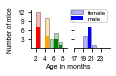

In [3]:
########################################################################
##### Figure 1b ##### 
########################################################################

set_rcParams()
fig, axes = plt.subplots(1,2, sharey=True, figsize=[1.4, 0.7])
for ax in axes:
    set_plot(ax)

colors = ['red', 'orange', 'green', 'blue']
axes_indices = [0, 0, 0, 1]
for subjects, age, sex, criteria, color, axi in zip(control_subjects, ages, sexes, group_criteria, colors, axes_indices): 
    bins = np.arange(criteria['min_age'], criteria['max_age']+1, 1)

    ### creat histogram for each age group
    total = []
    male = []
    for i in range(len(bins)-1):
        inds = np.flatnonzero((age>=bins[i])*(age<bins[i+1]))
        total.append(len(inds))
        male.append(len(inds)-np.sum(sex[inds]))
    
    age_bin = bins[:-1]+0.5
    axes[axi].bar(age_bin, total, facecolor=color, alpha=0.3, edgecolor='black', linewidth=1)       
    axes[axi].bar(age_bin, male, color=color)
    
axes[0].set_xticks(range(2,9,2))
axes[0].set_yticks(range(3,13,3))
axes[0].set_xlim(1,9)
axes[0].set_ylabel('Number of mice')
axes[1].set_xticks(range(17,24,2))
axes[1].set_xlim(17,25)
axes[1].spines['left'].set_visible(False)
axes[1].legend(['female', 'male'], bbox_to_anchor=(1, 1.1), fontsize=6, borderpad=0.1, labelspacing=0.1)
plt.text(10.5, -6.5, 'Age in months', fontsize=7)
plt.savefig('MiceAgeSexDistribution.svg')

### ITI distribution

In [4]:
#### Compute the ITI distribution in control subjects
all_time_info = np.array(Get_timeInfo(control_subjects, MaxDay=30))

bigmat=[]
ti=1 #0 for session duration, 1 for iti length
for at in all_time_info:
    bigmat = at[:,:,ti] if len(bigmat)==0 else np.concatenate((bigmat, at[:,:,ti]), axis=0)

print('Mean ITI, SD ITI, min ITI, max ITI')
print(np.nanmean(bigmat),np.nanstd(bigmat), np.nanmin(bigmat), np.nanmax(bigmat))

Mean ITI, SD ITI, min ITI, max ITI
4.10747789121021 0.5870485526437839 3.137014869888473 8.811723035230349


## Figure 1c
Learning curves of control mice

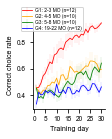

In [5]:
all_learningCurves = PlotMean(control_subjects, colors=['red','orange','green','blue'], legends=['G1: 2-3 MO ','G2: 4-5 MO ','G3: 5-8 MO ','G4: 19-22 MO '], ylims = [0.3, 0.95], figscale=0.16)
plt.savefig('AllControlLearningCurves.svg')

### Fraction of mice that exceeded 80% correct

In [6]:
#### Compute the number of session taken to reach 80%
for group_name, learningCurves in zip(control_group_names, all_learningCurves):
    Dday = []
    for lc in learningCurves:
        days = np.flatnonzero(lc>=0.8)
        Dday.append(days[0]) if len(days)>0 else Dday.append(np.nan)
    print(group_name)
    print('Fraction of mice exceeding 80%, Mean training days, SD')
    print(1-len(np.flatnonzero(np.isnan(Dday)))/len(Dday), np.nanmean(Dday), np.nanstd(Dday))

2-3 mo-Control-WT
Fraction of mice exceeding 80%, Mean training days, SD
1.0 12.333333333333334 8.013876853447538
4-5 mo-Control-WT
Fraction of mice exceeding 80%, Mean training days, SD
0.4 13.75 5.673402858955108
5-8 mo-Control-WT
Fraction of mice exceeding 80%, Mean training days, SD
0.30000000000000004 20.0 5.887840577551898
19-22 mo-Control-WT
Fraction of mice exceeding 80%, Mean training days, SD
0.0 nan nan


## Figure 1d left
Early-phase performance comparision

Kruskal-Wallis H-test: H = 11.913, p = 0.008

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 156.000, n1 = 12, n2 = 10, uncorrected p = 0.249
Group 1 vs Group 3: W = 172.000, n1 = 12, n2 = 10, uncorrected p = 0.027
Group 1 vs Group 4: W = 201.000, n1 = 12, n2 = 12, uncorrected p = 0.004
Group 2 vs Group 3: W = 121.000, n1 = 10, n2 = 10, uncorrected p = 0.241
Group 2 vs Group 4: W = 150.000, n1 = 10, n2 = 12, uncorrected p = 0.023
Group 3 vs Group 4: W = 130.000, n1 = 10, n2 = 12, uncorrected p = 0.339

corrected p-values:
Group 1 vs Group 2: corrected p = 0.298
Group 1 vs Group 3: corrected p = 0.054
Group 1 vs Group 4: corrected p = 0.021
Group 2 vs Group 3: corrected p = 0.298
Group 2 vs Group 4: corrected p = 0.054
Group 3 vs Group 4: corrected p = 0.339


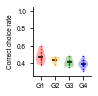

In [202]:
########################################################################
##### Figure 1d left ##### 
########################################################################

colors1=['red', 'orange', 'green', 'blue']
labels=['G1','G2','G3','G4']

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

Frac =[]
for i, subject_list in enumerate(control_subjects): 
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[:3])
        Perf.append(learning)

    Perf = np.array(Perf)
    Frac.append(Perf)
    plt.plot(i*np.ones(Perf.shape[0]), Perf, '.', color=colors1[i], markersize=1)
    vp = plt.violinplot(Perf, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')

plt.ylabel('Correct choice rate')
plt.xticks(range(len(labels)), labels, fontsize=7)
plt.ylim(0.25, 1.05)
plt.savefig('AllControlEarlyLearning.svg')


groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}

postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 1d right
Late-phase performance comparision

Kruskal-Wallis H-test: H = 25.118, p = 0.000

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 185.000, n1 = 12, n2 = 10, uncorrected p = 0.002
Group 1 vs Group 3: W = 196.000, n1 = 12, n2 = 10, uncorrected p = 0.000
Group 1 vs Group 4: W = 222.000, n1 = 12, n2 = 12, uncorrected p = 0.000
Group 2 vs Group 3: W = 113.000, n1 = 10, n2 = 10, uncorrected p = 0.571
Group 2 vs Group 4: W = 145.000, n1 = 10, n2 = 12, uncorrected p = 0.052
Group 3 vs Group 4: W = 141.000, n1 = 10, n2 = 12, uncorrected p = 0.093

corrected p-values:
Group 1 vs Group 2: corrected p = 0.004
Group 1 vs Group 3: corrected p = 0.000
Group 1 vs Group 4: corrected p = 0.000
Group 2 vs Group 3: corrected p = 0.571
Group 2 vs Group 4: corrected p = 0.078
Group 3 vs Group 4: corrected p = 0.111


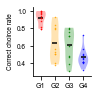

In [203]:
########################################################################
##### Figure 1d right ##### 
########################################################################

colors1=['red', 'orange', 'green', 'blue']
labels=['G1','G2','G3','G4']

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

Frac =[]
for i, subject_list in enumerate(control_subjects): 
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[25:30])
        Perf.append(learning)

    Perf = np.array(Perf)
    Frac.append(Perf)
    plt.plot(i*np.ones(Perf.shape[0]), Perf, '.', color=colors1[i], markersize = 1)
    vp = plt.violinplot(Perf, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')

plt.ylabel('Correct choirce rate')
plt.xticks(range(len(labels)), labels, fontsize=7)
plt.ylim(0.25, 1.05)
plt.savefig('AllControlLateLearning.svg')


groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}

postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 1e
Learning curves as a function of trial numbers

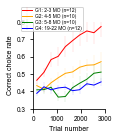

In [9]:
########################################################################
##### Figure 1e ##### 
########################################################################
all_learningCurvesByTrials = PlotMean_trials(control_subjects, colors=['red','orange','green','blue'], legends=['G1: 2-3 MO ','G2: 4-5 MO ','G3: 5-8 MO ','G4: 19-22 MO '], ylims = [0.3, 0.8], figscale=0.16)
plt.savefig('AllControlLearningCurvesTrials.svg')

## Figure 1f
Sex-age comparision of take performance 

Kruskal-Wallis H-test: H = 17.991, p = 0.000

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 24.000, n1 = 5, n2 = 7, uncorrected p = 0.193
Group 1 vs Group 3: W = 40.000, n1 = 5, n2 = 5, uncorrected p = 0.012
Group 1 vs Group 4: W = 50.000, n1 = 5, n2 = 7, uncorrected p = 0.006
Group 2 vs Group 3: W = 63.000, n1 = 7, n2 = 5, uncorrected p = 0.006
Group 2 vs Group 4: W = 77.000, n1 = 7, n2 = 7, uncorrected p = 0.002
Group 3 vs Group 4: W = 27.000, n1 = 5, n2 = 7, uncorrected p = 0.417

corrected p-values:
Group 1 vs Group 2: corrected p = 0.232
Group 1 vs Group 3: corrected p = 0.018
Group 1 vs Group 4: corrected p = 0.012
Group 2 vs Group 3: corrected p = 0.012
Group 2 vs Group 4: corrected p = 0.012
Group 3 vs Group 4: corrected p = 0.417


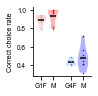

In [204]:
########################################################################
##### Figure 1f ##### 
########################################################################

# Compile mouse information per sex
group_criteria3 = [
    combine_criteria(2, 3,   ['experiment', 'sex', 'genotype'], ['Control', 'Female', 'WT']),
    combine_criteria(2, 3,   ['experiment', 'sex', 'genotype'], ['Control', 'Male', 'WT']),
    combine_criteria(19, 22, ['experiment', 'sex', 'genotype'], ['Control', 'Female', 'WT']),
    combine_criteria(19, 22, ['experiment', 'sex', 'genotype'], ['Control', 'Male', 'WT']),
] 
subjects3, group_names3, ages3, sexes3, dates3 = group_subjects(group_criteria3, SubjectDB)

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1=['lightcoral', 'red', 'cornflowerblue', 'blue']
labels=['G1F','M','G4F','M']
place = [0, 0.8, 2, 2.8]
Frac =[]
for i, subject_list in enumerate(subjects3): 
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        y = FullContrastPerf(sessions)
        sub_day = min(len(y),40)
        learning = np.nanmean(y[25:30])

        Perf.append(learning)
    Perf = np.array(Perf)

    Frac.append(Perf)
    plt.plot(place[i]*np.ones(Perf.shape[0]), Perf, '.', color=colors1[i], alpha = 1, markersize=1)
    vp = plt.violinplot(Perf, [place[i]], showmeans=True, showextrema=False, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    
plt.ylabel('Correct choice rate', fontsize=7)
plt.xticks(place, labels)
plt.savefig('AllControlLateLearningFvM.svg')


groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}

postHoc_mutipleComparisons(groups, method='fdr_bh')

### Compute Movement Parameters

In [ ]:
#### No need to run it again. But this computes kinematic variables for each session
    
# for subject_list in control_subjects:
#     for subject in subject_list:
#         print(subject)
#         dc = process_mouse(subject) 

import random

NBmean_list = []
RTmedian_list = []
PSmedian_list = []
CCmean_list = []

numSessions = 30
for j,subject_list in enumerate(control_subjects):
    mean_nb = np.full((len(subject_list),numSessions), np.nan)
    median_rt = np.full((len(subject_list),numSessions), np.nan)
    median_ps = np.full((len(subject_list),numSessions), np.nan)
    mean_corr = np.full((len(subject_list),numSessions), np.nan)
    for i, subject in enumerate(subject_list):
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        sessions = sessions[:min(numSessions,len(sessions))]
        
        for si, session in enumerate(sessions):
            session_path=one.eid2path(session['url'])
            trial_data = read_trial_data(session_path)  
            Kin = np.load(Path(one.eid2path(session['url']),'alf/Kinematics10.npy'), allow_pickle=True)
            interval_list = Kin[3]
            wheelPosition = Kin[4]
            velocity = Kin[5]
            Allchoices = Kin[6]
            
            trajectories = []
            choices = []
            for interval, vel, choice in zip(interval_list, velocity, Allchoices):
                if len(interval)>0 and (interval[-1][0]+250) <len(vel): #100
                    inds = np.arange(250) + interval[-1][0] #Kinmean2
                    trajectories.append(vel[inds]) #Kinmean2
                    choices.append(choice)
            trajectories = np.array(trajectories)
            choices = np.array(choices)
            
            corrs = []
            for ci, choice in enumerate([-1,1]):
                trials = np.flatnonzero(choices==choice)
                trjs = trajectories[trials]
                corr=[]
                if len(trials)>10:
                    for rep in range(1000):
                        rints = random.sample(range(len(trials)), k=2)
                        r,p = stats.pearsonr(trjs[rints[0]],trjs[rints[1]])
                        corr.append(r)
                    corrs.append(np.nanmean(corr))
                else:
                    corrs.append(np.NaN)
            mean_corr[i,si]=np.nanmean(corrs)
            
            #mean_nb[i,si] = np.nanmedian(Kin[0]) #Kinmedian
            Kin[0] = np.array(Kin[0], dtype='float')
            Kin[0][np.flatnonzero(Kin[0]<1)] = np.NaN
            mean_nb[i,si] = np.nanmean(Kin[0].astype('float')) # number of bouts
            median_rt[i,si] = np.nanmedian(np.array(Kin[-1], dtype='float')) #rt
            median_ps[i,si] = np.nanmedian(np.array(Kin[2], dtype='float')) #peak spead
    NBmean_list.append(mean_nb)
    RTmedian_list.append(median_rt) 
    PSmedian_list.append(median_ps) 
    CCmean_list.append(mean_corr)

np.save('Kinmean10.npy', np.array([RTmedian_list,PSmedian_list,CCmean_list,NBmean_list],dtype='object'))

## Supplementary Figure 1
Motor learning curves

W = 90.000, n1 = 12, n2 = 12, uncorrected p = 0.001
Early-phase Reaction time:p=0.001
W = 195.000, n1 = 12, n2 = 12, uncorrected p = 0.010
Early-phase Peak speed:p=0.010
W = 122.000, n1 = 12, n2 = 12, uncorrected p = 0.112
Early-phase Movement correlation:p=0.112
W = 96.500, n1 = 12, n2 = 12, uncorrected p = 0.002
Late-phase Reaction time:p=0.002
W = 162.000, n1 = 12, n2 = 12, uncorrected p = 0.507
Late-phase Peak speed:p=0.507
W = 163.000, n1 = 12, n2 = 12, uncorrected p = 0.470
Late-phase Movement correlation:p=0.470


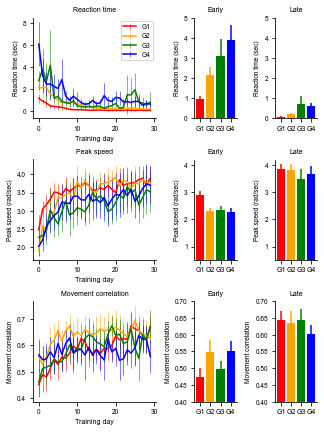

In [310]:
########################################################################
#### Supplementary Figure 1 ####
########################################################################

import scipy
import matplotlib.gridspec as gridspec
import scipy.stats as stats

set_rcParams()

colors1=['red','orange','green','blue']


mean_lists = np.load('Kinmean10.npy',allow_pickle=True)[:]
fig = plt.figure(tight_layout=True, figsize=np.array([4.5,6]))
gs = gridspec.GridSpec(len(mean_lists)-1,4)

titles=['Reaction time', 'Peak speed','Movement correlation','Number of bouts']
ylabels=['Reaction time (sec)', 'Peak speed (rad/sec)','Movement correlation','Number of bouts']
for i, mean_list in enumerate(mean_lists[:-1]):
    axe = fig.add_subplot(gs[i, :2])
    set_plot(axe)

    for j, mean_nb in enumerate(mean_list): 
        x = mean_nb
        y = np.nanmean(x,axis=0)[:]
        ye = (np.nanstd(x, axis=0)/np.sqrt(len(mean_list)))[:]
        plt.errorbar(range(len(y)), y, ye, color=colors1[j],elinewidth=0.5, errorevery=1)
    plt.title(titles[i],fontsize=7)
    plt.ylabel(ylabels[i])
    plt.xlabel('Training day', fontsize=7)

    if i==0:
        plt.legend(['G1','G2','G3','G4'])

for i, mean_list in enumerate(mean_lists[:-1]):
    axe = fig.add_subplot(gs[i, 2])
    set_plot(axe)
    
    LRs = []
    for j, mean_nb in enumerate(mean_list): 
        Taus = []
        for k, x in enumerate(mean_nb):
            tau=np.nanmean(x[:3])
            Taus.append(tau)

        LRs.append(Taus)
        plt.bar(j,np.nanmean(Taus),color=colors1[j])
        plt.errorbar(j, np.nanmean(Taus), np.nanstd(Taus)/np.sqrt(len(Taus)),color=colors1[j])
    plt.xticks(range(len(LRs)),labels=['G1','G2','G3','G4'],fontsize=7)
    plt.title('Early', fontsize=7)
    plt.ylabel(ylabels[i])
    if i==0:
        plt.ylim(0,5)
    elif i==1:
        plt.ylim(0.5,4.2)
    elif i==2:
        plt.ylim(0.4,0.7)
    elif i==3:
        plt.ylim(0, 3)
        

    x = LRs[0]
    y = LRs[3]
    r, p=stats.ranksums(x,y)
    stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
    n1 = len(x)
    n2 = len(y)
    rank = n1*(n1+1)/2
    print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
    print(f'Early-phase {titles[i]}:p={p:1.3f}')  
    
for i, mean_list in enumerate(mean_lists[:-1]):
    axe = fig.add_subplot(gs[i, 3])
    set_plot(axe)

    
    LRs = []
    for j, mean_nb in enumerate(mean_list): 
        Taus = []
        for k, x in enumerate(mean_nb):
            tau = np.nanmean(x[-3:])
   
            Taus.append(tau)

        LRs.append(Taus)
        plt.bar(j,np.nanmean(Taus),color=colors1[j])
        plt.errorbar(j, np.nanmean(Taus), np.nanstd(Taus)/np.sqrt(len(Taus)),color=colors1[j])
    plt.xticks(range(len(LRs)),labels=['G1','G2','G3','G4'],fontsize=7)
    plt.ylabel(ylabels[i])
    plt.title('Late', fontsize=7)
    if i==0:
        plt.ylim(0,5)
    elif i==1:
        plt.ylim(0.5,4.2)
    elif i==2:
        plt.ylim(0.4, 0.7)
    elif i==3:
        plt.ylim(0, 3)

    x = LRs[0]
    y = LRs[3]
    r, p=stats.ranksums(x,y)
    stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
    n1 = len(x)
    n2 = len(y)
    rank = n1*(n1+1)/2
    print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
    print(f'Late-phase {titles[i]}:p={p:1.3f}')
plt.savefig('Kinematics.svg')

# Figure 2 and Supplementary Figure 2 Block 
This block includes cells that process data from control experiment and plot them.

### Q-learning simulation

In [70]:
# Simulated reward function: define some environment logic
def get_reward(state, action):
    # Define "correct" action per state
    if state == 0 and action == 1:
        return 1
    elif state == 1 and action == 0:
        return 1
    else:
        return 0

# Environment setup
num_states = 2
num_actions = 2

# Initialize Q-table

# Hyperparameters
alpha = 0.1     # learning rate
gamma = 0     # discount factor
episodes = 10000

QlearningCurves = []
QEarlySwitch = []
QLateSwitch = []
for epsilon in [0, 0.0002, 0.0005, 0.0015]:
    # Training loop
    Rewards = []
    switches = []
    Reverse_switches = []
    for rep in range(1000):
        Q = np.zeros((num_states, num_actions))
        rewards = []
        switch = []
        preaction = 0
        for episode in range(episodes):
            # Start at random state
            state = random.choice([0, 1])
            noise = random.gauss(0,1)

            # ε-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
            else:
                action = np.argmax(Q[state])

            # Get reward
            reward = get_reward(state, action)
            
            switch.append(1) if not(action == preaction) else switch.append(0)
            preaction = action
            rewards.append(reward)

            # No next state since it's a single-step environment, but we'll follow standard Q-learning update
            Q[state, action] += alpha * (reward + gamma * np.max(Q[state]) - Q[state, action])
        switches.append(np.array(np.cumsum(switch)/(np.arange(len(switch))+1)))
        Reverse_switches.append(np.cumsum(np.array(switch)[np.arange(len(switch)-1, -1, -1)])/(np.arange(len(switch))+1))
        Rewards.append(np.array(rewards))
    mRewards = np.nanmean(np.array(Rewards), axis=0)
    mSwitch = np.nanmean(np.array(switches), axis=0)
    sSwitch = np.nanmean(np.array(Reverse_switches), axis=0)

    QlearningCurves.append(mRewards)
    QEarlySwitch.append(mSwitch)
    QLateSwitch.append(sSwitch)
    #plt.plot(np.lib.stride_tricks.sliding_window_view(mRewards,1).mean(axis=-1))

    # Display learned Q-values
    print("Learned Q-table:")
    print(Q)

    # Show policy
    print("\nLearned policy (best action per state):")
    for state in range(num_states):
        print(f"State {state}: Take action {np.argmax(Q[state])}")


# np.save('QStimulation_rewards.npy', QlearningCurves)
# np.save('QStimulation_mean_cum_switch.npy', QEarlySwitch)
# np.save('QStimulation_reverse_mean_cum_switch.npy', QLateSwitch)

Learned Q-table:
[[0. 0.]
 [1. 0.]]

Learned policy (best action per state):
State 0: Take action 0
State 1: Take action 0
Learned Q-table:
[[0. 0.]
 [1. 0.]]

Learned policy (best action per state):
State 0: Take action 0
State 1: Take action 0
Learned Q-table:
[[0. 1.]
 [1. 0.]]

Learned policy (best action per state):
State 0: Take action 1
State 1: Take action 0
Learned Q-table:
[[0. 1.]
 [1. 0.]]

Learned policy (best action per state):
State 0: Take action 1
State 1: Take action 0


## Figure 2b
Simulated Q-learning curves

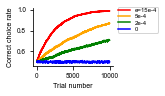

In [21]:
########################################################################
##### Figure 2b ##### 
########################################################################

set_rcParams()

colors = ['red', 'orange', 'green','blue']
epsilon = np.array([0.0015, 0.0005, 0.0002, 0])*1000

QlearningCurves = np.load('QStimulation_rewards.npy', allow_pickle=True)
QEarlySwitch = np.load('QStimulation_mean_cum_switch.npy', allow_pickle=True)
QLateSwitch = np.load('QStimulation_reverse_mean_cum_switch.npy', allow_pickle=True)

QlearningCurves = np.array(QlearningCurves)
QEarlySwitch = np.array(QEarlySwitch)
QLateSwitch = np.array(QLateSwitch)

###### Learning curves for different exploration rates
plt.figure(figsize=[3.7,0.8])
ax = plt.axes((0,0,0.3, 1))
set_plot(ax)
for i, r, s in zip (np.arange(len(QlearningCurves)), reversed(QlearningCurves), reversed(QEarlySwitch)):
    plt.plot(np.lib.stride_tricks.sliding_window_view(r,20).mean(axis=-1), color=colors[i])
plt.legend(labels=['e=15e-4', '5e-4', '2e-4', '0'], loc='right', bbox_to_anchor=(1.6, 0.8), borderpad=0.1, labelspacing=0.2, fontsize=6)
plt.xlabel('Trial number', fontsize=7)
plt.ylabel('Correct choice rate', fontsize=7)

plt.savefig('LearningSimul1.svg')

## Figure 2c-d
Simulated early- and late-phase exploration and late-phase exploration versus task performance

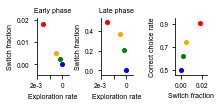

In [22]:
########################################################################
##### Figure 2c-d #####
########################################################################

##### Early Exploration rate VS Early phase switch
set_rcParams()
plt.figure(figsize=[3.7,0.8])
ax = plt.axes((0, 0, 0.12, 1))
set_plot(ax)
for i, ms, ss in zip (range(len(QEarlySwitch)), reversed(QEarlySwitch), reversed(QLateSwitch)):
    plt.plot(epsilon[i], ms[200], '.', markersize=8, color=colors[i])
plt.ylabel('Switch fraction', fontsize=7)
plt.xlabel('Exploration rate', fontsize=7)
plt.xticks(np.arange(0, 2.1, 1), labels=['0','', '2e-3'])
plt.xlim(-0.5, 2)
ax.invert_xaxis()
plt.ylim(-0.005, 0.021)
plt.title('Early phase', fontsize=7)

##### Late Exploration rate VS Late phase switch
ax = plt.axes((0.24, 0, 0.12, 1))
set_plot(ax)
for i, ms, ss in zip (range(len(QEarlySwitch)), reversed(QEarlySwitch), reversed(QLateSwitch)):
    plt.plot(epsilon[i], ss[200], '.', markersize=8, color=colors[i])
plt.ylabel('Switch fraction', fontsize=7)
plt.xlabel('Exploration rate', fontsize=7)
plt.xticks(np.arange(0, 2.1, 1), labels=['0','', '2e-3'])
plt.xlim(-0.5, 2)
ax.invert_xaxis()
plt.ylim(-0.05, 0.53)
plt.title('Late phase', fontsize=7)

##### Early phase switch VS Learning
ax = plt.axes((0.52, 0, 0.12, 1))
set_plot(ax)
for i, r, ms in zip (range(len(QEarlySwitch)), reversed(QlearningCurves), reversed(QEarlySwitch)):
    plt.plot(ms[200], np.mean(r[-9000:]), '.', markersize=8, color=colors[i])
plt.ylabel('Correct choice rate', fontsize=7)
plt.xlabel('Switch fraction', fontsize=7)
plt.xticks(np.arange(0, 0.025, 0.02))
plt.yticks(np.arange(0.5, 1, 0.2))
plt.xlim(-0.005, 0.025)
plt.ylim(0.45, 0.95)

plt.savefig('QLearningSimulation.svg')

## Figure 2e & Supplementary Figure 2a
Early exploration comparaion of control mice

Kruskal-Wallis H-test: H = 14.029, p = 0.003

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 157.000, n1 = 12, n2 = 10, uncorrected p = 0.222
Group 1 vs Group 3: W = 163.500, n1 = 12, n2 = 10, uncorrected p = 0.099
Group 1 vs Group 4: W = 213.000, n1 = 12, n2 = 12, uncorrected p = 0.000
Group 2 vs Group 3: W = 115.500, n1 = 10, n2 = 10, uncorrected p = 0.449
Group 2 vs Group 4: W = 153.000, n1 = 10, n2 = 12, uncorrected p = 0.013
Group 3 vs Group 4: W = 136.000, n1 = 10, n2 = 12, uncorrected p = 0.176

corrected p-values:
Group 1 vs Group 2: corrected p = 0.267
Group 1 vs Group 3: corrected p = 0.198
Group 1 vs Group 4: corrected p = 0.002
Group 2 vs Group 3: corrected p = 0.449
Group 2 vs Group 4: corrected p = 0.040
Group 3 vs Group 4: corrected p = 0.264


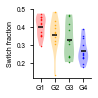

In [326]:
########################################################################
##### Figure 2e #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
labels=['G1','G2','G3','G4']
NT = 200
Frac =[]
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        fraction = FractionSwitch3(sessions[:3], numTR=NT, opto=0)

        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction

    if len(fractions)>0:
        Frac.append(fractions)
        plt.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
        vp = plt.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
        for pc in vp['bodies']:
            pc.set_facecolor(colors1[i])
        vp['cmeans'].set_color('black')
plt.ylabel('Switch fraction', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)
plt.savefig(f'AgeSwitch{NT}.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 2f & Supplementary Figure 2b
Early exploration versus learning

0.21089663501286113 0.5105689344070776
-0.2121212121212121 0.5563057751029299
-0.34650615989763683 0.3266572580343008
0.651489615554662 0.021724735067411623
0.3704304575753254 0.013316985315328081 44


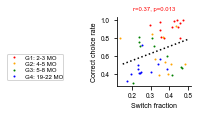

In [327]:
########################################################################
##### Figure 2f #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([2.6,1.2])*0.8)
axe = plt.axes([0.5,0,0.5,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
NT = 200 #Vary this number 100-400 for Supplementary Figure2
Frac = []
PerfMat = []
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch3(sessions[:3], numTR=NT)
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
        
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[25:30])
        Perf.append(learning)
    Perf = np.array(Perf)
    if len(Perf)>0:
        ind = np.flatnonzero(~(np.isnan(Perf)))
        xf =fractions
        r,p = stats.spearmanr(xf[ind], Perf[ind])        
        print(r,p)
        if len(Frac)==0:
            Frac = fractions  
            PerfMat = np.array(Perf)
        else:
            Frac = np.concatenate((Frac,fractions))
            PerfMat = np.concatenate((PerfMat,np.array(Perf)))
        x = fractions
        y = Perf
        plt.plot(x, y, '.', color=colors1[i], markersize=2)

ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
print(r, p, len(x))
res = stats.linregress(x, y)
x2 = np.arange(0.15, 0.55, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:', label='fitted line')

plt.xlabel('Switch fraction', fontsize=7)
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.ylabel('Correct choice rate', fontsize=7)
plt.title(f'r={r:1.2f}, p={p:1.3f}', color='r', fontsize=6)
plt.legend(['G1: 2-3 MO', 'G2: 4-5 MO', 'G3: 5-8 MO', 'G4: 19-22 MO'], loc='upper left', bbox_to_anchor=(-1.5, 0.5), borderpad=0.1, labelspacing=0.2, fontsize=6)
plt.savefig(f'ExploreLearningCorr{NT}.svg')

## Figure 2g
Mean early exploration versus learning

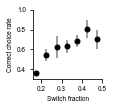

In [25]:
########################################################################
##### Figure 2g #####
########################################################################

set_rcParams()

plt.figure(figsize=np.array([1.2,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

step=0.05
offset=0.15

for i in range(12):
    ind = np.flatnonzero((Frac>=i*step+offset)*(Frac<i*step+step+offset))
    if len(ind)>1:
        plt.plot(i*step+step/2+offset, np.nanmean(PerfMat[ind]), '.', color='black', markersize=10)
        plt.errorbar(i*step+step/2+offset, np.nanmean(PerfMat[ind]), np.nanstd(PerfMat[ind])/np.sqrt(len(ind)), color='gray')
plt.xlabel('Switch fraction')
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.yticks([0.4, 0.6, 0.8, 1.0])
plt.ylabel('Correct choice rate')
#plt.title(f'r={r:1.2f}, p<{p:1.3f}', color='r', fontsize=7)
#plt.grid()
plt.savefig('ExploreLearningCorr2.svg')

## Figure 2h
Early exploration versus learning in the oldest mice

0.651489615554662 0.021724735067411623
0.651489615554662 0.021724735067411623 12


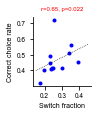

In [208]:
########################################################################
##### Figure 2h #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
NT = 200
Frac = []
PerfMat = []
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    if i==3:
        for subject in subject_list:
            sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])

            fraction = FractionSwitch3(sessions[:3], numTR=NT)
            fractions = np.hstack((fractions, fraction)) if fractions.size else fraction

            y = FullContrastPerf(sessions)
            learning = np.nanmean(y[25:30])
            Perf.append(learning)
        Perf = np.array(Perf)
        if len(Perf)>0:
            ind = np.flatnonzero(~(np.isnan(Perf)))
            xf =fractions
            r,p = stats.spearmanr(xf[ind], Perf[ind])        
            print(r,p)
            if len(Frac)==0:
                Frac = fractions  
                PerfMat = np.array(Perf)
            else:
                Frac = np.concatenate((Frac,fractions))
                PerfMat = np.concatenate((PerfMat,np.array(Perf)))
            x = fractions
            y = Perf
            plt.plot(x, y, '.', color=colors1[i])
                    
ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
print(r, p, len(x))
res = stats.linregress(x, y)
x2 = np.arange(0.15, 0.46, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:', label='fitted line', linewidth=0.7)

plt.xlabel('Switch fraction', fontsize=7)
plt.xticks([0.2, 0.3, 0.4])
plt.ylabel('Correct choice rate', fontsize=7)
plt.title(f'r={r:1.2f}, p={p:1.3f}', color='r', fontsize=6)
plt.savefig('ExploreLearningCorr_old.svg')

## Supplementary Figure 2c
The GLM schema

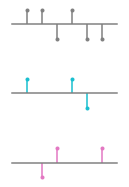

In [28]:
########################################################################
##### Supplmentary Figure 2c #####
########################################################################
set_rcParams()
plt.figure(figsize=[1.6, 3.2])

bigMat = [
    [np.nan, np.nan, -1,  1, np.nan,  np.nan, 1, np.nan],
    [np.nan, 1,  np.nan,  np.nan, 1, -1, np.nan, np.nan],
    [np.nan, 1, 1, -1, 1 ,-1, -1, np.nan],
]
yl = [f'/Unrewarded\nchoice', f'Rewarded\nchoice',  'Stimulus', ]
lmt = ['C6', 'C9', 'C7']
for i in range(3):
    ax = plt.axes([0, 0.3*i, 1, 0.15])
    set_plot(ax)
    y = bigMat[i]
    x = np.arange(len(y))
    plt.stem(x, y, linefmt= lmt[i], markerfmt = '.'+ lmt[i], basefmt = 'grey')
    plt.ylim(-1.2, 1.2)
    ax.set_axis_off()

plt.savefig('GLMdemo.svg')    

## Supplementary Figure 2d top
GLM-fit exploration comparison of control mice

Kruskal-Wallis H-test: H = 11.924, p = 0.008

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 153.000, n1 = 12, n2 = 10, uncorrected p = 0.339
Group 1 vs Group 3: W = 153.000, n1 = 12, n2 = 10, uncorrected p = 0.339
Group 1 vs Group 4: W = 208.000, n1 = 12, n2 = 12, uncorrected p = 0.001
Group 2 vs Group 3: W = 102.000, n1 = 10, n2 = 10, uncorrected p = 0.850
Group 2 vs Group 4: W = 150.000, n1 = 10, n2 = 12, uncorrected p = 0.023
Group 3 vs Group 4: W = 145.000, n1 = 10, n2 = 12, uncorrected p = 0.052

corrected p-values:
Group 1 vs Group 2: corrected p = 0.407
Group 1 vs Group 3: corrected p = 0.407
Group 1 vs Group 4: corrected p = 0.005
Group 2 vs Group 3: corrected p = 0.850
Group 2 vs Group 4: corrected p = 0.069
Group 3 vs Group 4: corrected p = 0.104


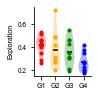

In [321]:
########################################################################
##### Supplementary Figure 2d top  #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

labels =['G1','G2','G3','G4']
colors1=['red', 'orange', 'green', 'blue']
Frac = []
PerfMat = []

key = "IBL_Fit3"

for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sub_i = np.flatnonzero(SubjectDB['name']==subject)[0]
        FITs = SubjectDB[key][sub_i]
        fraction = np.array([])
        for FIT in FITs[:1]:
            Parameters = FIT['Parameters'] 
            if 'IBL' in key:
                a = (Parameters[1] + Parameters[2])
                Switch = 1/(1+np.exp(a))
        fraction = Switch 
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    plt.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i])
    vp = plt.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)

    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')

plt.ylabel('Exploration', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)
plt.savefig('AgeSwitch_'+ key + '.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Supplementary Figure 2d bottom
GLM-fit exploration versus learning

0.36146446338378796 0.015917687325556637


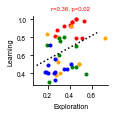

In [328]:
########################################################################
##### Supplementary Figure 2d bottom #####
########################################################################
set_rcParams()
plt.figure(figsize=np.array([2.6,1.2])*0.8)
axe = plt.axes([0.5,0,0.5,1])
set_plot(axe)

labels =['G1','G2','G3','G4']
colors1=['red', 'orange', 'green', 'blue']
Frac = []
PerfMat = []

key = 'IBL_Fit3'

for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sub_i = np.flatnonzero(SubjectDB['name']==subject)[0]
        FITs = SubjectDB[key][sub_i]
        fraction = np.array([])
        for FIT in FITs[:1]:
            Parameters = FIT['Parameters'] 
            if 'IBL' in key:
                a = (Parameters[1] + Parameters[2])
                Switch = 1/(1+np.exp(a))
        fraction = Switch 
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
        
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[25:30])
        Perf.append(learning)
    
    Perf = np.array(Perf)
    ind = np.flatnonzero(~(np.isnan(Perf)))
    xf =fractions
    if len(Frac)==0:
        Frac = fractions  
        PerfMat = np.array(Perf)
    else:
        Frac = np.concatenate((Frac,fractions))
        PerfMat = np.concatenate((PerfMat,np.array(Perf)))
    #print(np.nanmedian(fractions, axis=0))
    x = fractions
    y = Perf
    plt.plot(x, y, '.', color=colors1[i])

ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
print(r,p)
res = stats.linregress(x, y)
x2 = np.arange(0.1, 0.7, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:', label='fitted line')
plt.xlabel('Exploration', fontsize=7)
plt.xticks([0.2, 0.4, 0.6])
plt.ylabel('Learning', fontsize=7)
plt.title(f'r={r:1.2f}, p<{p:1.2f}', color='r', fontsize=6)
plt.savefig('ExploreLearningCorr_' + key +'.svg')

## Supplementary Figure 4
Win-switch, random exploration

Kruskal-Wallis H-test: H = 11.912, p = 0.0077

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: U = 94.000, uncorrected p = 0.0272
Group 1 vs Group 3: U = 85.500, uncorrected p = 0.0992
Group 1 vs Group 4: U = 130.000, uncorrected p = 0.0009
Group 2 vs Group 3: U = 46.000, uncorrected p = 0.7913
Group 2 vs Group 4: U = 81.000, uncorrected p = 0.1760
Group 3 vs Group 4: U = 78.000, uncorrected p = 0.2480

corrected p-values:
Group 1 vs Group 2: corrected p = 0.0815
Group 1 vs Group 3: corrected p = 0.1983
Group 1 vs Group 4: corrected p = 0.0053
Group 2 vs Group 3: corrected p = 0.7913
Group 2 vs Group 4: corrected p = 0.2640
Group 3 vs Group 4: corrected p = 0.2976
0.4413316750531582 0.15093472887541384
-0.33333333333333326 0.34659350708733405
-0.29696969696969694 0.4047016712701569
-0.06338185336835989 0.844853681587023


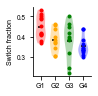

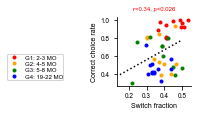

In [87]:
########################################################################
##### Figure 2e #####
##### Win-switch random exploration
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
labels=['G1','G2','G3','G4']
NT = 200
Frac =[]
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        fraction = FractionSwitch1(sessions[:3], numTR=NT, opto=0)

        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction

    if len(fractions)>0:
        Frac.append(fractions)
        plt.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i])
        vp = plt.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
        for pc in vp['bodies']:
            pc.set_facecolor(colors1[i])
        vp['cmeans'].set_color('black')
plt.ylabel('Switch fraction', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)
#plt.savefig(f'AgeSwitch{NT}.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

########################################################################
##### Figure 2f #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([2.6,1.2])*0.8)
axe = plt.axes([0.5,0,0.5,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
NT = 200 #Vary this number 100-400 for Supplementary Figure2
Frac = []
PerfMat = []
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch1(sessions[:3], numTR=NT)
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
        
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[25:30])
        Perf.append(learning)
    Perf = np.array(Perf)
    if len(Perf)>0:
        ind = np.flatnonzero(~(np.isnan(Perf)))
        xf =fractions
        r,p = stats.spearmanr(xf[ind], Perf[ind])        
        print(r,p)
        if len(Frac)==0:
            Frac = fractions  
            PerfMat = np.array(Perf)
        else:
            Frac = np.concatenate((Frac,fractions))
            PerfMat = np.concatenate((PerfMat,np.array(Perf)))
        x = fractions
        y = Perf
        plt.plot(x, y, '.', color=colors1[i])

ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
res = stats.linregress(x, y)
x2 = np.arange(0.15, 0.55, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:', label='fitted line')

plt.xlabel('Switch fraction', fontsize=7)
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.ylabel('Correct choice rate', fontsize=7)
plt.title(f'r={r:1.2f}, p<{p:1.3f}', color='r', fontsize=6)
plt.legend(['G1: 2-3 MO', 'G2: 4-5 MO', 'G3: 5-8 MO', 'G4: 19-22 MO'], loc='upper left', bbox_to_anchor=(-1.5, 0.5), borderpad=0.1, labelspacing=0.2, fontsize=6)
#plt.savefig(f'ExploreLearningCorr{NT}.svg')

## Supplementary Figures
Lose-switch, directed exploration

Kruskal-Wallis H-test: H = 13.295, p = 0.0040

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: U = 58.000, uncorrected p = 0.9212
Group 1 vs Group 3: U = 83.000, uncorrected p = 0.1379
Group 1 vs Group 4: U = 129.500, uncorrected p = 0.0010
Group 2 vs Group 3: U = 65.000, uncorrected p = 0.2730
Group 2 vs Group 4: U = 101.000, uncorrected p = 0.0076
Group 3 vs Group 4: U = 88.000, uncorrected p = 0.0698

corrected p-values:
Group 1 vs Group 2: corrected p = 0.9212
Group 1 vs Group 3: corrected p = 0.2069
Group 1 vs Group 4: corrected p = 0.0060
Group 2 vs Group 3: corrected p = 0.3276
Group 2 vs Group 4: corrected p = 0.0227
Group 3 vs Group 4: corrected p = 0.1396
0.14711055835105272 0.6482152290826798
-0.17575757575757575 0.6271883447764844
-0.41818181818181815 0.22911284098281892
0.6923076923076924 0.012593030496094107


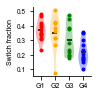

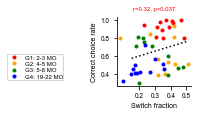

In [88]:
########################################################################
##### Figure 2e #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
labels=['G1','G2','G3','G4']
NT = 200
Frac =[]
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        fraction = FractionSwitch2(sessions[:3], numTR=NT, opto=0)

        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction

    if len(fractions)>0:
        Frac.append(fractions)
        plt.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i])
        vp = plt.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
        for pc in vp['bodies']:
            pc.set_facecolor(colors1[i])
        vp['cmeans'].set_color('black')
plt.ylabel('Switch fraction', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)
#plt.savefig(f'AgeSwitch{NT}.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

########################################################################
##### Figure 2f #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([2.6,1.2])*0.8)
axe = plt.axes([0.5,0,0.5,1])
set_plot(axe)

colors1=['red', 'orange', 'green', 'blue']
NT = 200 #Vary this number 100-400 for Supplementary Figure2
Frac = []
PerfMat = []
for i, subject_list in enumerate(control_subjects): 
    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch2(sessions[:3], numTR=NT)
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
        
        y = FullContrastPerf(sessions)
        learning = np.nanmean(y[25:30])
        Perf.append(learning)
    Perf = np.array(Perf)
    if len(Perf)>0:
        ind = np.flatnonzero(~(np.isnan(Perf)))
        xf =fractions
        r,p = stats.spearmanr(xf[ind], Perf[ind])        
        print(r,p)
        if len(Frac)==0:
            Frac = fractions  
            PerfMat = np.array(Perf)
        else:
            Frac = np.concatenate((Frac,fractions))
            PerfMat = np.concatenate((PerfMat,np.array(Perf)))
        x = fractions
        y = Perf
        plt.plot(x, y, '.', color=colors1[i])

ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
res = stats.linregress(x, y)
x2 = np.arange(0.15, 0.55, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:', label='fitted line')

plt.xlabel('Switch fraction', fontsize=7)
plt.xticks([0.2, 0.3, 0.4, 0.5])
plt.ylabel('Correct choice rate', fontsize=7)
plt.title(f'r={r:1.2f}, p<{p:1.3f}', color='r', fontsize=6)
plt.legend(['G1: 2-3 MO', 'G2: 4-5 MO', 'G3: 5-8 MO', 'G4: 19-22 MO'], loc='upper left', bbox_to_anchor=(-1.5, 0.5), borderpad=0.1, labelspacing=0.2, fontsize=6)
#plt.savefig(f'ExploreLearningCorr{NT}.svg')

# Figure 3
This block includes cells that compile mouse information from GCaMP6s imaging experiment, process and plot data.

## Load subject database for GCaMP6s imaging experiment

In [32]:
##### Load subject database and compile mice in GCaMP6S imaging experiment

SubjectDB = np.load('2025Nature_SubjectDB.npy', allow_pickle = True).item()

group_criteria = [
    combine_criteria(2, 4,   ['experiment'], ['GC']),
    combine_criteria(15, 24, ['experiment'], ['GC']),
] 
GC_subjects, GC_group_names, GC_ages, GC_sexes, GC_dates = group_subjects(group_criteria, SubjectDB)

## Figure 3c
Swtich versus stay trial activity of an example mouse

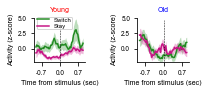

In [209]:
########################################################################
##### Figure 3c #####
########################################################################

set_rcParams()

Young = { 'Subjects': ['H0940'], 
         'Dates':['2024-04-18'] }
Old = {'Subjects': ['H0923'], 
       'Dates':['2024-02-20'] }

colors = ['forestgreen', 'mediumvioletred']
colors2 = ['red', 'blue']
titles = ['Young', 'Old']

fr=30
offset_time = 1
total_time = 2
sw_time = 0.2
wl = total_time*fr
off = offset_time*fr
sw = int(sw_time*fr)

AllCells=[]

plt.figure(figsize = np.array([2.4, 2.8]))
for gi, group in enumerate([Young, Old]):
    Subjects = group['Subjects']
    Dates = group['Dates']
    allCells = []
    for subject, date in zip (Subjects, Dates):
        trial_data = read_behavioral_data(subject, date)
        neural_data, FrameNum, TrialNum = read_cell_data(subject, date)

        trials_list = []
        choices = trial_data['choice']
        pre_choices = np.hstack(([0], choices[:-1]))
        for ci in range(2):
            if ci == 0:
                trials = np.flatnonzero(choices*pre_choices<0)
            elif ci == 1:
                trials = np.flatnonzero(choices*pre_choices>0)
            trials_list.append(trials)        
        
        trials_list = np.array(trials_list, dtype=object)
        cells = np.flatnonzero((neural_data['iscell'][:,0])*(neural_data['iscell'][:,1]>0))
      
        axe = plt.axes([0.6*gi, 0.6, 0.3, 0.22])
        which_cells = [cells[23], 28]
        smooth_signal,  zsmooth_signal, zNS = align_cell(which_cells[gi], trial_data, neural_data, FrameNum, TrialNum, align_to = 'stimOn', window_length = wl, smooth_window=sw, offset = off, FrameRate=fr)
        
        mtrace = []
        for j in range(2):
            mtrace.append(np.nanmean(smooth_signal[trials_list[j],:], 0))
        mtrace = np.array(mtrace)
        zsmooth_signal = (smooth_signal-np.nanmean(mtrace))/np.nanstd(mtrace)

        time =  (np.arange(smooth_signal[0].shape[-1]) - off)/fr + (sw-1)/2/fr

        set_plot(axe)
        mtrace2 =[]
        for j in range(2):
            means = np.nanmean(zsmooth_signal[trials_list[j], :], axis=0)
            ses = np.nanstd(zsmooth_signal[trials_list[j], :], axis=0)/np.sqrt(len(trials_list[j]))
            plt.fill_between(time, means+ses, means-ses, color = colors[j], alpha=0.3, linewidth=0)
            plt.plot(time, means, color = colors[j])
            mtrace2.append(means)
        plt.axvline(0, -0.15, 0.95, color='black', linestyle='--', linewidth=0.5)
        plt.ylim(-2.2, 5)
        plt.ylabel('Activity (z-score)', fontsize=7)
        plt.xlabel('Time from stimulus (sec)', fontsize=7)
        plt.xticks([-0.7, 0, 0.7], labels = [f'{t:1.1f}' for t in [-0.7, 0, 0.7]])
        if gi==0:
            plt.legend(['Switch', 'Stay'], loc='upper left', bbox_to_anchor=(0, 1.1), fontsize=6, borderpad=0.1, labelspacing=0.2)
            plt.title('Young', color='r')
        plt.title(titles[gi], color=colors2[gi], fontsize=7)

plt.savefig('ExampleNeurons.svg')

## Run this first for Figure 3d, e, f, g, h, i, j, k

In [335]:
##### Run this first for Figure 3d, e, f, g, h, i, j, k
fr=30
offset_time = 1
offset_time = 1
total_time = 2
sw_time = 0.2
wl = total_time*fr
off = offset_time*fr
sw = int(sw_time*fr)
time = (np.arange(wl - sw + 1) - off)/fr + (sw-1)/2/fr

AllCells=[]
MeanSig=np.array([])
FSwitch = []
for group in range(2): 
    Wsw = []
    allCells = []
    for subject, date in zip (GC_subjects[group], GC_dates[group]):
        print(f'Processing {subject}')
        trial_data = read_behavioral_data(subject, date)
        neural_data, FrameNum, TrialNum = read_cell_data(subject, date)

        sessions = one.alyx.rest('sessions', 'list', subject=subject, date_range=[date, date], number='000')
        
        trials_list = []
        choices = trial_data['choice']
        pre_choices = np.hstack(([0], choices[:-1]))
        for ci in range(2):
            if ci == 0:
                trials = np.flatnonzero(choices*pre_choices<0)
            elif ci == 1:
                trials = np.flatnonzero(choices*pre_choices>0)
            trials_list.append(trials)        
        
        trials_list = np.array(trials_list, dtype=object)
        cells = np.flatnonzero(neural_data['iscell'][:,0])
      
        plt.figure(figsize=[2,2])
        mean_sig, sd_sig, signal, zNS = plot_population_condition(trial_data, neural_data, FrameNum, TrialNum, cells = cells, align_to = 'stimOn',  window_length = wl, smooth_window=sw, offset = off, 
                                                                trials_list = trials_list, FrameRate = fr, zScore=0, plot=False)   
        zsignal = np.full_like(signal, np.nan)
        for ci in range(len(cells)):
            my = np.nanmean(signal[:, ci, :])
            sy = np.nanstd(signal[:,ci,:])
            zsignal[:, ci,: ] = (signal[:, ci, :] - my)/sy
            
        time = (np.arange(signal.shape[2]) - off)/fr + (sw-1)/2/fr

        tind = np.flatnonzero((time>=-0.45)*(time<=-0.15))
       
        MeanSig = np.mean(np.mean(zsignal[:,:,tind], axis=-1),axis=-1) if len(MeanSig)==0 else np.vstack((MeanSig,np.mean(np.mean(zsignal[:,:,tind], axis=-1),axis=-1)))
        sig = np.nanmean(zsignal[0][:,tind]-zsignal[1][:,tind], axis=-1)
        FSwitch.append(len(np.flatnonzero(sig>0.5))/(sig.shape[0]))
        allCells = zsignal if len(allCells)==0 else np.concatenate((allCells,zsignal), axis=1)
    AllCells.append(allCells)
FSwitch = np.array(FSwitch)

Processing H0849
Processing H0851
Processing H0940
Processing H1005
Processing H0975
Processing H0857
Processing H0872
Processing H0873
Processing H0923
Processing H0926
Processing H1020


<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

## Figure 3d
Swtich versus stay trial population activity

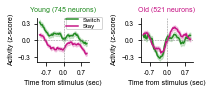

In [211]:
########################################################################
##### Figure 3d : Population activity
########################################################################
set_rcParams()    
plt.figure(figsize = np.array([2.4, 2.8]))
colors2 = ['forestgreen', 'mediumvioletred']
for j, allCells in enumerate(AllCells):
    ax = plt.axes([j*0.6, 0.6, 0.3, 0.22])
    set_plot(ax)
    for i, sig in enumerate(allCells):
        meanCells = np.nanmean(sig, axis=0)
        stdCells = np.nanstd(sig, axis=0)/np.sqrt(sig.shape[0])
        plt.fill_between(time, meanCells-stdCells, meanCells+stdCells, color=colors2[i], alpha=0.2)
        plt.plot(time, meanCells, color=colors2[i])
    plt.xticks(np.arange(-0.67, 0.7, 0.67), labels=['-0.7', '0.0', '0.7'])
    plt.ylim(-0.4, 0.4)
    plt.yticks([-0.3, 0, 0.3])
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.ylabel('Activity (z-score)', fontsize=7)
    plt.xlabel('Time from stimulus (sec)', fontsize=7)
    plt.title(f'{titles[j]} ({len(sig)} neurons)', fontsize=7, color=colors[j])
    if j==0:
        plt.legend(['Switch', 'Stay'], loc='upper right', bbox_to_anchor=(1.3, 1.1), borderpad=0.1, labelspacing=0.2, fontsize=6)

plt.savefig('GC_AVGyoungVSold.svg')

## Figure 3e
Switch-Stay heat map of PPC population

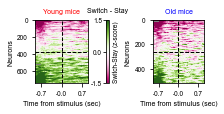

In [212]:
########################################################################
##### Figure 3e #####
########################################################################

set_rcParams()    
plt.figure(figsize=np.array([2.4, 1.1]))

titles = ['Young mice', 'Old mice']
colors = ['red', 'blue']
which_cells = [23, 28]
a = []
for gi, allCells in enumerate(AllCells):    
    ax = plt.axes([gi*0.68, 0, 0.48-0.18*gi, 0.8])
    z = (allCells[0]-allCells[1])

    half_ind = 23
    half_ind = 10
    ms = np.nanmean(z[:, :half_ind], axis=1)
    inds = ms.argsort()  

    y = z[inds,:]
    row = np.flatnonzero(inds==which_cells[gi])
    a.append(y[row,:])

    im = plt.imshow(y, cmap='PiYG', aspect='auto', vmin=-1.5, vmax=1.5)
    plt.axhline(row, 0, 0.1, color='grey', linestyle='-', linewidth = 1)
    plt.axhline(len(inds)/2, 0, 1, color='black', linestyle='--', linewidth = 1)
    plt.axvline(z.shape[1]/2-0.5, 0, z.shape[0], color='black', linestyle='--', linewidth = 1)
    tind = np.arange(6, z.shape[1], 21)
    plt.xticks(tind, labels = [f'{t:1.1f}' for t in time[tind]])
    plt.ylabel('Neurons', fontsize=7)
    plt.xlabel('Time from stimulus (sec)', fontsize=7)
    plt.title(titles[gi], fontsize=7, color=colors[gi])
    #ax.invert_yaxis()
    if gi==0:
        cbar = plt.colorbar(im, pad=0.21, label='Switch-Stay (z-score)', ticks=[-1.5, 0, 1.5], format='%1.1f')
        cax = cbar.ax
        cax.yaxis.set_ticks_position('left')
        cax.tick_params(axis='y', pad=0.01)
ax = plt.axes([0,0,1,0.9])
ax.set_axis_off()
plt.text(0.3, 1, 'Switch - Stay', fontsize=7)
plt.savefig('GC_PopulationDeltaHeatmap.svg')

## Figure 3f-g
Mean Switch-Stay activity

[-0.45       -0.41666667 -0.38333333 -0.35       -0.31666667 -0.28333333
 -0.25       -0.21666667 -0.18333333 -0.15        0.18333333  0.35
  0.38333333  0.41666667  0.45        0.48333333  0.51666667]
Num of Time points:55
3.634004985266562
[-0.48333333 -0.45       -0.41666667 -0.38333333 -0.35       -0.31666667
 -0.28333333 -0.25       -0.21666667 -0.18333333 -0.15        0.21666667
  0.31666667  0.51666667  0.55        0.58333333]
Num of Time points:55
13.282883281062965


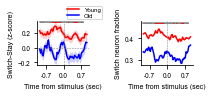

In [348]:
#########################################################################
#### Figure 3f-g #####
########################################################################

##### delta z traces
from scipy.stats import chi2_contingency
set_rcParams()    
plt.figure(figsize = np.array([2.4, 2.8]))
ax = plt.axes([0, 0.6, 0.3, 0.22])
set_plot(ax)
titles = ['Young', 'Old']
colors2 = ['red', 'blue']
for j, allCells in enumerate(AllCells):
    sig = allCells[0] - allCells[1]
    meanCells = np.nanmean(sig, axis=0)
    stdCells = np.nanstd(sig, axis=0)/np.sqrt(sig.shape[0])
    plt.fill_between(time, meanCells-stdCells, meanCells+stdCells, color=colors2[j], alpha=0.2, linewidth=0)
    plt.plot(time, meanCells, color=colors2[j])
plt.legend(titles, loc='upper right', bbox_to_anchor=(1.3, 1.4), borderpad=0.1, labelspacing=0.2, fontsize=6)
pvals=[]
ts = []
for ti in range(AllCells[0].shape[-1]):
    sig1 = AllCells[0][0][:,ti] - AllCells[0][1][:,ti]
    sig2 = AllCells[1][0][:,ti] - AllCells[1][1][:,ti]
    
    r, p = stats.ttest_ind(sig1,sig2)
    pvals.append(p)
    ts.append(r)

from statsmodels.stats.multitest import multipletests
# Apply Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
plt.plot(time[tinds], np.ones(len(tinds),)*0.35, color='grey', marker='*', markersize=0.2)

alpha = 0.001
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
plt.plot(time[tinds], np.ones(len(tinds),)*0.35, 'r*', markersize=0.2)
print(time[tinds])
print(f'Num of Time points:{len(pvals)}')
print(np.min(np.abs(np.array(ts)[rejected])))

plt.xticks(np.arange(-0.67, 0.7, 0.67), labels=['-0.7', '0.0', '0.7'])
plt.ylim(-0.24, 0.36)
plt.yticks([-0.2, 0, 0.2])
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Switch-Stay (z-score)', fontsize=7)
plt.xlabel('Time from stimulus (sec)', fontsize=7)

ax = plt.axes([0.6, 0.6, 0.3, 0.22])
set_plot(ax)
for j, allCells in enumerate(AllCells):
    sig = allCells[0] - allCells[1]
    
    fracSwitch = []
    for ti in range(sig.shape[1]):
        inds = np.intersect1d(np.arange(ti-5, ti+5), np.arange(0, sig.shape[1]))
        msig = np.nanmean(sig[:,inds], axis=-1)
        fracSwitch.append(len(np.flatnonzero(msig>0.5))/len(msig))

    
    plt.plot(time, fracSwitch, color=colors2[j])
plt.xticks(np.arange(-0.67, 0.7, 0.67), labels=['-0.7', '0.0', '0.7'])
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Switch neuron fraction', fontsize=7)
plt.xlabel('Time from stimulus (sec)', fontsize=7)

pvals = []
ts = []
for ti in range(AllCells[0].shape[-1]):
    mat = []
    for j in range(2):
        sig = AllCells[j][0]-AllCells[j][1]
        inds = np.intersect1d(np.arange(ti-5, ti+5), np.arange(0, AllCells[0].shape[-1]))
        msig = np.nanmean(sig[:,inds], axis=-1)
        mat.append(np.array([len(np.flatnonzero(msig>0.5)), len(msig)-len(np.flatnonzero(msig>0.5))]))
                                         
    mat = np.array(mat)
    chi2, p, dof, expected = chi2_contingency(mat)
    pvals.append(p)
    ts.append(chi2)
tinds = np.flatnonzero(np.array(pvals)*AllCells[0].shape[-1]<0.05)    
from statsmodels.stats.multitest import multipletests
# Apply Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
plt.plot(time[tinds], np.ones(len(tinds),)*0.47, color='grey', marker='*', markersize=0.2)

alpha = 0.001
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
plt.plot(time[tinds], np.ones(len(tinds),)*0.47, 'r*', markersize=0.2)
print(time[tinds])
print(f'Num of Time points:{len(pvals)}')
print(np.min(np.abs(np.array(ts)[rejected])))
plt.savefig('GC_SingleNeurons.svg')

[2.83581344523605,
 3.1450202925799515,
 2.6597490388379663,
 3.407606154016526,
 3.373185339619185,
 2.4289089360117875,
 1.8919008373214963,
 1.6894255178592008,
 2.2269939516587187,
 1.956898995256525,
 0.9195513332004684,
 2.107936395177647,
 3.059879733082439,
 3.026425456292327,
 3.73741307378778,
 3.7967172199106454,
 4.937733907015904,
 5.564691981682179,
 5.636524235190463,
 5.528378620571831,
 3.8292098185778394,
 4.4175778907839796,
 4.193815395105422,
 3.9402073847729553,
 2.9466176783578613,
 1.9339760055509303,
 2.135518700226398,
 1.451010238331456,
 1.5262875599921206,
 1.8602826566930832,
 2.221463959137486,
 2.997600504754939,
 3.5927344152171288,
 3.6379469859545246,
 3.419300106122717,
 2.9008168213127465,
 3.011974740669365,
 3.0445142470869735,
 3.6531158135809445,
 4.131626907796964,
 3.634004985266562,
 3.9912257453758726,
 3.8167292240105155,
 3.8817838054819793,
 3.19006063732559,
 2.546193956881694,
 2.947561521386855,
 2.6753362863589967,
 2.368023697646515,

## Figure 3h
Distribution of ITI (switch-stay) values

6.4712636315288865 1.7623087169589954e-10 745
-2.036377272913196 0.04221862563916972 521
5.754064369505686 1.0920127328958843e-08 745 521
0.14950855994538123 1.8834298785019854e-06 745 521
p<0.000


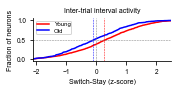

In [278]:
########################################################################
##### Figure 3h #####
########################################################################

##### Cumulative distribution of delta
set_rcParams()
plt.figure(figsize = np.array([2.4, 0.6]))
titles = ['Young', 'Old']
colors2 = ['red', 'blue']

ax = plt.axes([0, 0, 0.8, 1])
set_plot(ax)
bigMat = []
for j, allCells in enumerate(AllCells):
    sig = allCells[0] - allCells[1]

    tind = np.flatnonzero((time>=-0.60)*(time<=-0.3))
    tind = np.flatnonzero((time>=-0.45)*(time<=-0.15))
    fracSwitch = []
    for ci in range(sig.shape[0]):
        fracSwitch.append(np.nanmean(sig[ci, tind]))
    bigMat.append(fracSwitch)
    bins = np.arange(-2.5, 5, 0.005)
    hist, bin_edges = np.histogram(fracSwitch, bins)
    plt.plot(bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2, np.cumsum(hist/np.sum(hist)), color=colors2[j])
plt.legend(titles, loc='upper left', bbox_to_anchor=(0, 1), borderpad=0.1, labelspacing=0.2, fontsize=6)
plt.xlim(-2.1,2.5)
plt.ylabel('Fraction of neurons', fontsize=7)
plt.xlabel('Switch-Stay (z-score)', fontsize=7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(bigMat[0],0), color='red', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(bigMat[1],0), color='blue', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.title('Inter-trial interval activity', fontsize=7)
plt.savefig('GC_CumSum.svg')
r,p = stats.mstats.ttest_onesamp(bigMat[0],0)
print(r, p, len(bigMat[0]))
r,p = stats.mstats.ttest_onesamp(bigMat[1],0)
print(r, p, len(bigMat[1]))
r,p = stats.ttest_ind(bigMat[0], bigMat[1])
print(r, p, len(bigMat[0]), len(bigMat[1]))
ks_stat, p = stats.ks_2samp(bigMat[0], bigMat[1])
print(ks_stat, p, len(bigMat[0]), len(bigMat[1]))
print(f'p<{p:1.3f}')

## Figure 3i-j
ITI (switch-stay) values per mouse

3.903541841683062 0.011368656262946857
-1.309588374198902 0.2604881514081956
W = 50.000, n1 = 6, n2 = 5, uncorrected p = 0.014
2.556038601690775 0.01371083007813322 6 5
3.903541841683062 0.011368656262946857
-1.309588374198902 0.2604881514081956
W = 49.000, n1 = 6, n2 = 5, uncorrected p = 0.022
2.37346441585572 0.022478873366125265 6 5


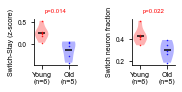

In [221]:
########################################################################
##### Figure 3i-j #####
############################################################

##### per mouse
set_rcParams()
plt.figure(figsize = np.array([2.4, 0.8]))
colors = ['red', 'blue']
titles = ['Young', 'Old']
N=6
bigMat =[]
labels = []
ax = plt.axes([0, 0.07, 0.25, 0.8])    
set_plot(ax)
for i in [0,1]:
    inds = np.arange(N) if i==0 else np.arange(N, MeanSig.shape[0],1)
    
    sig = MeanSig[inds, 0]-MeanSig[inds,1]
    vp = plt.violinplot(sig, [i], showmeans=True, showextrema=False, widths=0.5)
    for pc in vp['bodies']:
        pc.set_facecolor(colors[i])
    vp['cmeans'].set_color('black')
    plt.plot(i*np.full_like(sig, 1), sig, '.', color=colors[i], markersize=1)
    bigMat.append(sig)
    r, p= stats.ttest_rel(MeanSig[inds,0],MeanSig[inds,1])
    print(r,p)
    labels.append(titles[i]+f'\n(n={sig.shape[0]})')
plt.xlim(-0.3, 1.3)
plt.xticks([0, 1], labels=labels, fontsize=7)    
plt.ylabel('Switch-Stay (z-score)', fontsize=7)
r, p = stats.ranksums(bigMat[0], bigMat[1])

stat, p = stats.mannwhitneyu(bigMat[0], bigMat[1], alternative='two-sided')        
n1 = len(bigMat[0])
n2 = len(bigMat[1])
rank = n1*(n1+1)/2
print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")

plt.title(f'p={p:1.3f}', color='r', fontsize=6)
print(r, p, len(bigMat[0]), len(bigMat[1]))

ax = plt.axes([0.57, 0.07, 0.25, 0.8])    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
labels = []
bigMat = []
for i in [0,1]:
    inds = np.arange(N) if i==0 else np.arange(N, MeanSig.shape[0],1)
    
    sig = FSwitch[inds]
    vp = plt.violinplot(sig, [i], showmeans=True, showextrema=False, widths=0.5)
    for pc in vp['bodies']:
        pc.set_facecolor(colors[i])
    vp['cmeans'].set_color('black')
    plt.plot(i*np.full_like(sig, 1), sig, '.', color=colors[i], markersize=1)
    bigMat.append(sig)
    r, p= stats.wilcoxon(MeanSig[inds,0],MeanSig[inds,1])
    r, p= stats.ttest_rel(MeanSig[inds,0],MeanSig[inds,1])
    print(r,p)
    labels.append(titles[i]+f'\n(n={sig.shape[0]})')
plt.xlim(-0.3, 1.3)
plt.xticks([0, 1], labels=labels, fontsize=7)
plt.ylabel('Switch neuron fraction', fontsize=7)
r, p = stats.ranksums(bigMat[0], bigMat[1])

stat, p = stats.mannwhitneyu(bigMat[0], bigMat[1], alternative='two-sided')        
n1 = len(bigMat[0])
n2 = len(bigMat[1])
rank = n1*(n1+1)/2
print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")

plt.title(f'p={p:1.2f}', color='r', fontsize=6)
print(r, p, len(bigMat[0]), len(bigMat[1]))
plt.savefig('GC_youngVSoldPerMouse.svg')

## Figure 3k
ITI mean switch versus stay activity per mouse

ShapiroResult(statistic=0.9321306347846985, pvalue=0.5966536402702332)
3.903541841683062 0.011368656262946857 6
ShapiroResult(statistic=0.8838554620742798, pvalue=0.3271487355232239)
-1.309588374198902 0.2604881514081956 5


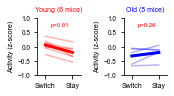

In [279]:
########################################################################
##### Figure 3k #####
########################################################################
set_rcParams()
time = (np.arange(AllCells[0].shape[2]) - off)/fr + (sw-1)/2/fr
N=6

############################################################
##### ITI activity comparison between switch versus stay
colors = ['red', 'blue']
titles = ['Young', 'Old']
plt.figure(figsize = np.array([2.0, 0.8]))
for i in [0,1]:
    inds = np.arange(N) if i==0 else np.arange(N, MeanSig.shape[0],1)
    ax = plt.axes([0.6*i, 0.07, 0.3, 1])
    set_plot(ax)


    plt.plot(MeanSig[inds,:].T, color=colors[i], alpha=0.3)
    plt.plot(np.nanmean(MeanSig[inds,:],axis=0), color=colors[i], linewidth=3)

    x = MeanSig[inds,0]
    y = MeanSig[inds,1]
    print(stats.shapiro(x-y))
#    r, p = stats.wilcoxon(x, y, alternative='greater')
    r, p= stats.ttest_rel(x, y)
    print(r, p, len(inds))
    plt.ylim([-1, 1])
    plt.xlim(-0.3, 1.3)
    plt.xticks([0, 1], labels=['Switch', 'Stay'], fontsize=7)
    plt.ylabel('Activity (z-score)', fontsize=7)
    plt.title(f'{titles[i]} ({len(inds)} mice)', fontsize=7, color=colors[i])
    plt.text(0.2, 0.7, f'p={p:1.2f}', color='r', fontsize=6)
plt.savefig('GC_youngVSold.svg')

# Figure 4
This block includes cells that compile mouse information from JEDI imaging experiment, process and plot data. The last part is for cFos data analysis.

## Load subject database for JEDI imaging experiment

In [222]:
##### Load subject database and compile mice in JEDI imaging experiment

SubjectDB = np.load('2025Nature_SubjectDB.npy', allow_pickle = True).item()

group_criteria = [
    combine_criteria(2, 4,   ['experiment'], ['JEDI']),
    combine_criteria(15, 24, ['experiment'], ['JEDI']),
] 
JEDI_subjects, JEDI_group_names, JEDI_ages, JEDI_sexes, JEDI_dates = group_subjects(group_criteria, SubjectDB)

## Run this first for Figure 4b-c

In [223]:
##### Run this first for Figure 4b-c
subject = 'H1209'
date = '2024-09-23'
fr=147
offset_time = 1
total_time = 2
sw_time = 0.2
wl = total_time*fr
off = offset_time*fr
sw = int(sw_time*fr)
time = (np.arange(wl - sw + 1) - off)/fr + (sw-1)/fr/2


trial_data = read_behavioral_data(subject, date)
neural_data, FrameNum, TrialNum = read_cell_data(subject, date, plane='plane1')
cells = np.flatnonzero(neural_data['iscell'][:,0])

S2PDirectory = '/HwangLab/Suite2P/'+date+'/'+ subject+'/'+subject + '-' + date + '-2P' + '/plane1'
volpy_name = f"volpy_data_d1_96_d2_352_d3_1_order_F_frames_399166_simple_{110}"
vpy = np.load(S2PDirectory + '/' + volpy_name + '.npy', allow_pickle=True).item()

choices = trial_data['choice']
pre_choices = np.hstack(([0], choices[:-1]))
exploration = (choices*pre_choices<0)

SNR = neural_data['SNR']
cells = np.flatnonzero((SNR>2)*(neural_data['iscell'][:,0]))

## Figure 4b
JEDI raw and processed signal of an example neuron 

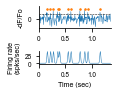

In [43]:
########################################################################
##### Figure 4b #####
########################################################################
plt.figure(figsize=np.array([1, 1.0])*1)

ax = plt.axes([0, 0.5, 1, 0.3])
set_plot(ax)

istart = 7800
window = np.arange(200)+istart

plt.plot(vpy['t'][0,window], linewidth=0.5)
inds = np.flatnonzero((vpy['spikes'][0]>=istart)*(vpy['spikes'][0]<istart+200))
plt.plot(vpy['spikes'][0][inds]-istart, np.full_like(inds, 200), '.', markersize=3)

plt.axhline(vpy['thresh'], color='black', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 200, 147/2), ['0', '0.5', '1.0'])
ax.set_yticks([0])
plt.ylabel('-dF/Fo', fontsize=7)
plt.xlim(0,200)
plt.ylim(-180,250)

ax = plt.axes([0, 0, 1, 0.18])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(neural_data['rates'][110,window], linewidth=0.5)
plt.xticks(np.arange(0, 200, 147/2), ['0', '0.5', '1.0'])
plt.xlabel('Time (sec)', fontsize=7)
plt.ylabel(f'Firing rate\n(spks/sec)', fontsize=7)
plt.xlim(0,200)

plt.savefig('Jedi_trace.svg')

## Figure 4c
Example raster switch versus stay trials

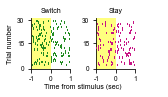

In [44]:
########################################################################
##### Figure 4c #####
########################################################################
set_rcParams()

plt.figure(figsize=np.array([1.8, 0.7]))
bigMat=[]
colors = ['forestgreen', 'mediumvioletred']
groups=['Switch', 'Stay']
for ci in range(2):
    if ci == 0:
        trials = np.flatnonzero(choices*pre_choices<0)
    elif ci == 1:
        trials = np.flatnonzero(choices*pre_choices>0)
    allMat=[]
    bax=plt.axes([0.5*ci, 0, 0.3, 1])
    set_plot(bax)
    plt.fill_between([0*147, 1*147],[0, 0], [1,1], color='yellow', alpha=0.5, linewidth=0)
    plt.xlim(0, 147*2)
    bax.set_xticks([0,147,147*2])
    bax.set_xticklabels(['-1', '0', '1'])
    if ci==0:
        plt.ylabel('Trial number', fontsize=7)
    plt.ylim(0, 1)
    bax.set_yticks([0.0,0.5,0.96])
    bax.set_yticklabels(['0', '15', '30'])
    plt.title(groups[ci], fontsize=7)
    for ti, tr in enumerate(trials[30:60]):
        ii= int(np.round((trial_data['stimOnTrigger_times'][tr]-trial_data['bitcode0'][tr]-1)*147))
        ie= int(np.round((trial_data['stimOnTrigger_times'][tr]-trial_data['bitcode0'][tr]+1)*147))
        frames = FrameNum[tr][0] + np.arange(ii, ii+294, 1)
        ax=plt.axes([0.5*ci, ti*0.03+0.07, 0.3, 0.03])    
        y = np.flatnonzero(vpy['t_rec'][0, frames]>150)
        plt.plot(y, np.full_like(y,1), '|', color=colors[ci])
        plt.xlim(0, 147*2)
        ax.set_axis_off()
        allMat.append(vpy['t_rec'][0, frames])
    bigMat.append(np.nanmean(allMat, axis=0))
ax = plt.axes([0,-0.4,1,1])
plt.text(0.1, 0, 'Time from stimulus (sec)', fontsize=7)
ax.set_axis_off()
plt.savefig('FiringExample.svg')

## Run this first for Figure 4d, e, f, g

In [349]:
##### Run this first for Figure 4d, e, f, g
fr=147
offset_time = 1
total_time = 2
sw_time = 0.2
wl = total_time*fr
off = offset_time*fr
sw = int(sw_time*fr)
time = (np.arange(wl - sw + 1) - off)/fr + (sw-1)/fr/2

AllCells=[]
MeanSig = np.array([])
for group in range(2):
    allCells = []
    for subject, date in zip (JEDI_subjects[group], JEDI_dates[group]):
        print(f'Processing {subject}')
        trial_data = read_behavioral_data(subject, date)
        neural_data, FrameNum, TrialNum = read_cell_data(subject, date, plane='plane1')
    
        sessions = one.alyx.rest('sessions', 'list', subject=subject, date_range=[date, date], number='000')
        
        trials_list = []
        choices = trial_data['choice']
        pre_choices = np.hstack(([0], choices[:-1]))
        for ci in range(2):
            if ci == 0:
                trials = np.flatnonzero(choices*pre_choices<0)
            elif ci == 1:
                trials = np.flatnonzero(choices*pre_choices>0)
            trials_list.append(trials)        
        
        trials_list = np.array(trials_list, dtype=object)
        SNR = neural_data['SNR']
        cells = np.flatnonzero((SNR>2)*(neural_data['iscell'][:,0]))
      
        plt.figure(figsize=[2,2])
        mean_sig, sd_sig, signal, zNS = plot_population_condition(trial_data, neural_data, FrameNum, TrialNum, cells = cells, align_to = 'stimOn',  
                                                                window_length = wl, smooth_window=sw, offset = off, trials_list = trials_list, 
                                                                FrameRate = fr, zScore=0, key='rates', plot=False)   
        zsignal = np.full_like(signal, np.nan)
        for ci in range(len(cells)):
            my = np.nanmean(signal[:, ci, :])
            sy = np.nanstd(signal[:,ci,:])
            zsignal[:, ci,: ] = (signal[:, ci, :] - my)/sy

        time = (np.arange(signal.shape[2]) - off)/fr + (sw-1)/2/fr
        tind = np.flatnonzero((time>=-0.60)*(time<=-0.3))

        MeanSig = np.mean(np.mean(zsignal[:,:,tind], axis=-1),axis=-1) if len(MeanSig)==0 else np.vstack((MeanSig,np.mean(np.mean(zsignal[:,:,tind], axis=-1),axis=-1)))
        a = (np.mean(zsignal[0,:,tind]-zsignal[1,:,tind], axis=0).argsort())
        allCells = zsignal if len(allCells)==0 else np.concatenate((allCells,zsignal), axis=1)
        
    AllCells.append(allCells)

Processing H1209
Processing H1254
Processing H1255
Processing H1564
Processing H1565
Processing H1164
Processing H1165
Processing H1166
Processing H1167


<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

## Figure S3a
Mean switch versus stay population activity

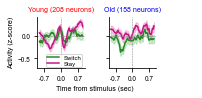

In [225]:
########################################################################
##### Figure 4d #####
########################################################################
plt.figure(figsize = np.array([2.2, 2.8]))
colors = ['forestgreen', 'mediumvioletred']
for j, allCells in enumerate(AllCells):
    ax = plt.axes([j*0.45, 0.4, 0.3, 0.25])
    set_plot(ax)
    for i, sig in enumerate(allCells):
        meanCells = np.nanmean(sig, axis=0)
        stdCells = np.nanstd(sig, axis=0)/np.sqrt(sig.shape[0])
        plt.fill_between(time, meanCells-stdCells, meanCells+stdCells, color=colors[i], alpha=0.2)
        plt.plot(time, meanCells, color=colors[i])
    plt.xticks(np.arange(-0.7, 0.71, 0.7), labels=['-0.7', '0.0', '0.7'])
    plt.ylim(-0.7, 0.4)
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    if j==0:
        plt.ylabel('Activity (z-score)', fontsize=7)
    else:
        ax.set_yticklabels([])
    plt.title(f'{titles[j]} ({len(sig)} neurons)', color=colors2[j], fontsize=7)
    if j==0:
        plt.legend(['Switch', 'Stay'], loc='lower right', bbox_to_anchor=(1.0, -0.04), borderpad=0.1, labelspacing=0.2, fontsize=6)
ax = plt.axes([0, 0.4, 1, 0.25])
ax.set_axis_off()
plt.text(0.12, -0.44, 'Time from stimulus (sec)', fontsize=7)

plt.savefig('JEDIz_youngVSold.svg')

## Figure S3bc
Mean switch-stay activity

Num of Time points:266
2.6233099195630794
[-0.60544218 -0.59863946 -0.59183673 -0.58503401 -0.57823129 -0.57142857
 -0.56462585 -0.55782313 -0.55102041 -0.54421769 -0.53741497 -0.53061224
 -0.52380952 -0.5170068  -0.51020408 -0.50340136 -0.49659864 -0.48979592
 -0.4829932  -0.47619048 -0.46938776 -0.46258503 -0.45578231 -0.44897959
 -0.44217687 -0.43537415 -0.42857143 -0.42176871 -0.41496599 -0.40816327
 -0.40136054 -0.39455782 -0.3877551  -0.38095238 -0.37414966 -0.36734694
 -0.36054422 -0.3537415  -0.34693878 -0.34013605 -0.33333333 -0.32653061
 -0.31972789  0.05442177  0.06122449  0.1292517   0.13605442  0.14285714
  0.14965986]
Num of Time points:266
7.811773722058534
[-0.6122449  -0.60544218 -0.59863946 -0.59183673 -0.58503401 -0.57823129
 -0.57142857 -0.56462585 -0.55782313 -0.55102041 -0.54421769 -0.53741497
 -0.53061224 -0.52380952 -0.5170068  -0.51020408 -0.50340136 -0.49659864
 -0.48979592 -0.4829932  -0.47619048 -0.46938776 -0.46258503 -0.45578231
 -0.44897959 -0.44217687 -0

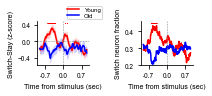

In [350]:
########################################################################
##### Figure 4e #####
########################################################################
from scipy.stats import chi2_contingency
set_rcParams()

compress = 1
time0 = (np.arange(AllCells[0].shape[2]) - off)/fr + (sw-1)/2/fr
subi = np.arange(0, len(time0), compress)
time = time0[subi]

N=5
AllCells2 = []
for i in range(2):
    allcells = AllCells[i]
    allcells2 = np.ones((allcells.shape[0], allcells.shape[1], len(subi)))*np.nan
    for j in range(2):
        allcells2[j] = allcells[j][:,subi] 
    AllCells2.append(allcells2)

colors = ['red', 'blue']
titles = ['Young', 'Old']

############################################################
############################################################
##### delta z traces
plt.figure(figsize = np.array([2.4, 2.8]))
colors2 = ['red', 'blue']
ax = plt.axes([0, 0.6, 0.3, 0.22])
set_plot(ax)
for j, allCells in enumerate(AllCells2):
    sig = allCells[0] - allCells[1]
    meanCells = np.nanmean(sig, axis=0)
    stdCells = np.nanstd(sig, axis=0)/np.sqrt(sig.shape[0])
    plt.fill_between(time, meanCells-stdCells, meanCells+stdCells, color=colors2[j], alpha=0.2, linewidth=0)
    plt.plot(time, meanCells, color=colors2[j])
plt.legend(titles, loc='upper right', bbox_to_anchor=(1.3, 1.4), borderpad=0.1, labelspacing=0.2, fontsize=6)
pvals=[]
ts=[]
for ti in range(AllCells2[0].shape[-1]):
    sig1 = AllCells2[0][0][:,ti] - AllCells2[0][1][:,ti]
    sig2 = AllCells2[1][0][:,ti] - AllCells2[1][1][:,ti]
    
    r, p = stats.ttest_ind(sig1,sig2)
    pvals.append(p)
    ts.append(r)

from statsmodels.stats.multitest import multipletests
# Apply Benjamini-Hochberg FDR correction
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
print(f'Num of Time points:{len(pvals)}')
print(np.min(np.abs(np.array(ts)[rejected])))

#tinds = np.flatnonzero(np.array(pvals)<0.05)    
plt.plot(time[tinds], np.ones(len(tinds),)*0.45, 'r*', markersize=0.2)
print(time[tinds])

plt.xticks(np.arange(-0.7, 0.71, 0.7), labels=['-0.7', '0.0', '0.7'])
#plt.ylim(-0.24, 0.36)
plt.yticks(np.arange(-0.4, 0.41, 0.4))
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Switch-Stay (z-score)', fontsize=7)
plt.xlabel('Time from stimulus (sec)', fontsize=7)

############################################################
############################################################
ax = plt.axes([0.6, 0.6, 0.3, 0.22])
set_plot(ax)

for j, allCells in enumerate(AllCells2):
    sig = allCells[0] - allCells[1]
    
    fracSwitch = []
    for ti in range(sig.shape[1]):
        inds = np.intersect1d(np.arange(ti-int(20/compress), ti+int(20/compress)), np.arange(0, sig.shape[1]))
        msig = np.nanmean(sig[:,inds], axis=-1)
        fracSwitch.append(len(np.flatnonzero(msig>0.5))/len(msig))

    
    plt.plot(time, fracSwitch, color=colors2[j])
plt.xticks(np.arange(-0.7, 0.71, 0.7), labels=['-0.7', '0.0', '0.7'])
plt.ylim(0.2, 0.46)
plt.yticks([0.2, 0.3, 0.4])
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
#plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Switch neuron fraction', fontsize=7)
plt.xlabel('Time from stimulus (sec)', fontsize=7)
#plt.title(f'{titles[j]} ({len(sig)} neurons)', fontsize=7, color=colors[j])
pvals = []
ts =[]
for ti in range(AllCells2[0].shape[-1]):
    mat = []
    for j in range(2):
        sig = AllCells2[j][0]-AllCells2[j][1]
        inds = np.intersect1d(np.arange(ti-20, ti+20), np.arange(0, AllCells2[0].shape[-1]))
        msig = np.nanmean(sig[:,inds], axis=-1)
        mat.append(np.array([len(np.flatnonzero(msig>0.5)), len(msig)-len(np.flatnonzero(msig>0.5))]))
                                         
    mat = np.array(mat)
    chi2, p, dof, expected = chi2_contingency(mat)
    pvals.append(p)
    ts.append(chi2)
alpha = 0.05
rejected, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
tinds = np.where(rejected)[0] 
plt.plot(time[tinds], np.ones(len(tinds),)*0.45, 'r*', markersize=0.2)
print(f'Num of Time points:{len(pvals)}')
print(np.min(np.abs(np.array(ts)[rejected])))
print(time[tinds])

plt.savefig('JEDI_SingleNeurons.svg')

## Figure S3e
Distribution of the mean ITI (switch-stay) activity

0.0006295443321724988
0.0036565246074307567
4.533681093938244 7.876648300528106e-06 208 158
0.22157984420642649 0.0002321936213278697 208 158
p<0.000


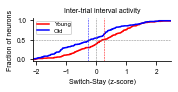

In [269]:
########################################################################
##### Figure 4f #####
########################################################################

##### Cumulative distribution of delta
plt.figure(figsize = np.array([2.4, 0.6]))
colors2 = ['red', 'blue']

ax = plt.axes([0, 0, 0.8, 1])
set_plot(ax)
bigMat = []
for j, allCells in enumerate(AllCells):
    sig = allCells[0] - allCells[1]

    tind = np.flatnonzero((time>=-0.60)*(time<=-0.3))
    fracSwitch = []
    for ci in range(sig.shape[0]):
        fracSwitch.append(np.nanmean(sig[ci, tind]))
    bigMat.append(fracSwitch)
    bins = np.arange(-2.5, 5, 0.005)
#    bins = np.arange(-2.5, 5, 0.1)
    hist, bin_edges = np.histogram(fracSwitch, bins)
    plt.plot(bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2, np.cumsum(hist/np.sum(hist)), color=colors2[j])
#    plt.plot(bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2, (hist/np.sum(hist)), color=colors2[j])
plt.legend(titles, loc='upper left', bbox_to_anchor=(0, 1), borderpad=0.1, labelspacing=0.2, fontsize=6)
plt.xlim(-2.1,2.5)
plt.ylabel('Fraction of neurons', fontsize=7)
plt.xlabel('Switch-Stay (z-score)', fontsize=7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(bigMat[0],0), color='red', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(bigMat[1],0), color='blue', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.title('Inter-trial interval activity', fontsize=7)
plt.savefig('JEDI_CumSum.svg')
r,p = stats.mstats.ttest_onesamp(bigMat[0],0)
print(p)
r,p = stats.mstats.ttest_onesamp(bigMat[1],0)
print(p)
r,p = stats.ttest_ind(bigMat[0], bigMat[1])
print(r, p, len(bigMat[0]), len(bigMat[1]))
ks_stat, p = stats.ks_2samp(bigMat[0], bigMat[1])
print(ks_stat, p, len(bigMat[0]), len(bigMat[1]))
print(f'p<{p:1.3f}')

## Figure S3d
Mean ITI switch versus stay activity per mouse

[[ 0.14237235 -0.19447015]
 [-0.10310403 -0.25733123]
 [-0.05066005 -0.13016905]
 [ 0.20746382 -0.01190257]
 [ 0.09821043 -0.47884974]]
ShapiroResult(statistic=0.9304481744766235, pvalue=0.5994300246238708)
3.1470140707058873 0.03461327063807326 5
[[-0.26530673 -0.57425449]
 [-0.23507486  0.14920113]
 [-0.39190017  0.01462208]
 [ 0.03066907  0.1122428 ]]
ShapiroResult(statistic=0.8753758668899536, pvalue=0.3192622661590576)
-0.8421900020193824 0.46152230029624003 4


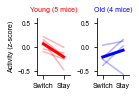

In [282]:
########################################################################
##### Figure 4g #####
########################################################################

set_rcParams()

N=5
time = (np.arange(AllCells[0].shape[2]) - off)/fr + (sw-1)/2/fr
colors2 = ['red', 'blue']
titles = ['Young', 'Old']
plt.figure(figsize = np.array([1.5, 0.8]))
for i in [0,1]:
    inds = np.arange(N) if i==0 else np.arange(N, MeanSig.shape[0],1)
    print(MeanSig[inds,:])
    ax = plt.axes([0.55*i, 0.07, 0.3, 1])
    set_plot(ax)

    plt.plot(MeanSig[inds,:].T, color=colors2[i], alpha=0.3)
    plt.plot(np.nanmean(MeanSig[inds,:],axis=0), color=colors2[i], linewidth=3)

    x = MeanSig[inds,0]
    y = MeanSig[inds,1]
    print(stats.shapiro(x-y))
#     r, p= stats.wilcoxon(x, y, alternative='greater')
#     print(r, p, len(inds))
    r, p= stats.ttest_rel(x, y)
    print(r, p, len(inds))
#    res = paired_permutation_test(x, y, statistic="mean", alternative="greater")
#    print(res)
    
    plt.ylim([-0.6, 0.6])
    plt.xlim(-0.3, 1.3)
    plt.xticks([0, 1], labels=['Switch', 'Stay'], fontsize=7)
    if i==0:
        plt.ylabel('Activity (z-score)', fontsize=7)
    plt.title(f'{titles[i]} ({len(inds)} mice)', pad=6, linespacing=1.5, fontsize=7, color=colors2[i])
plt.savefig('JEDI_youngVSoldDelta.svg')

## Run this first for Figure 4h, i, j

In [283]:
#### Run this first for Figure 4h, i, j
fr=147
offset_time = 1
total_time = 2
sw_time = 0.2
wl = total_time*fr
off = offset_time*fr
sw = int(sw_time*fr)
time = (np.arange(wl - sw + 1) - off)/fr + (sw-1)/fr/2
AllCells=[]
AllCells2=[]
MeanSig = []
for group in range(2):
    Spk_counts = []
    allCells = []
    allCells2 = []
    for subject, date in zip (JEDI_subjects[group], JEDI_dates[group]):
        trial_data = read_behavioral_data(subject, date)
        neural_data, FrameNum, TrialNum = read_cell_data(subject, date, plane='plane1')
    
        trials_list = np.array([np.flatnonzero(trial_data['choice'])], dtype=object)
        
        SNR = neural_data['SNR']
        cells = np.flatnonzero((SNR>2)*(neural_data['iscell'][:,0]))
        
        mean_sig, sd_sig, signal, zNS = plot_population_condition(trial_data, neural_data, FrameNum, TrialNum, cells = cells, align_to = 'stimOn',  
                                                                window_length = wl, smooth_window=sw, offset = off, trials_list = trials_list, 
                                                                FrameRate = fr, zScore=0, key='rates', plot=False)   

        #Stimulus onset aligned raw firing rates
        time = (np.arange(signal.shape[2]) - off)/fr + (sw-1)/2/fr
        tind = np.flatnonzero((time>=-0.60)*(time<=-0.3))
        allCells = signal if len(allCells)==0 else np.concatenate((allCells,signal), axis=1)

        #Raw firing rates across a whole imaging session
        signal = neural_data['rates'][cells,:]
        allCells2 = np.nanmean(signal, -1) if len(allCells2)==0 else np.concatenate((allCells2, np.nanmean(signal, -1)), axis=0)
        MeanSig.append(np.nanmean(signal))
        
    AllCells.append(allCells)
    AllCells2.append(allCells2)
MeanSig = np.array(MeanSig)

## Figure 4d
Raw firing rates heat map

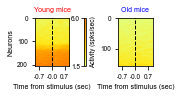

In [230]:
########################################################################
##### Figure 4h #####
########################################################################
set_rcParams()
    
N=5
titles = ['Young mice', 'Old mice']
colors = ['red', 'blue']
conditions = ['Switch', 'Stay']
time = (np.arange(AllCells[0].shape[2]) - off)/fr + (sw-1)/2/fr
plt.figure(figsize=np.array([2.4, 2.8]))
for condition in range(AllCells[0].shape[0]):
    for gi, allCells in enumerate(AllCells):    
        ax = plt.axes([gi*0.48, 0.5-condition*0.5, 0.33-0.13*gi, 0.24])
        z = allCells[condition]
        
        half_ind = round(z.shape[1]/2)
        ms = np.nanmean(z[:, :half_ind], axis=-1)
        inds2 = ms.argsort()  
        inds = []
        for ii in inds2:
            if not np.isnan(ms[ii]):
                inds.append(ii) 
        #im = plt.imshow(z[inds,:], cmap='PiYG', aspect='auto', vmin=1.5, vmax=6)
        im = plt.imshow(z[inds,:], cmap='Wistia', aspect='auto', vmin=1.5, vmax=6)
        plt.axvline(z.shape[1]/2-0.5, 0, z.shape[0], color='black', linestyle='--', linewidth = 1)
        tind = np.arange(30, z.shape[1], 100)
        plt.xticks(tind, labels = [f'{t:1.1f}' for t in time[tind]])
        if gi==0:
            plt.ylabel('Neurons', fontsize=7)
        plt.xlabel('Time from stimulus (sec)', fontsize=7) 

        if gi==0:
            cbar = plt.colorbar(im, pad=0.25, label='Activity (spks/sec)', ticks=[1.5, 6], format='%1.1f')
            cax = cbar.ax
            cax.yaxis.set_ticks_position('left')
            cax.tick_params(axis='y', pad=0.01)
        plt.title(titles[gi], fontsize=7, color=colors[gi])

plt.savefig('JEDI_PopulationHeatmap.svg')
plt.show()

## Figure 4e
Distribution of average firing rates

Difference of means: 11.529287286726316, p<0.000, 208, 158
Difference of distributions: 0.5124756572541382, p<0.000


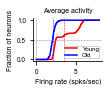

In [231]:
########################################################################
##### Figure 4i #####
########################################################################
plt.figure(figsize = np.array([1.2, 0.6]))
colors2 = ['red', 'blue']
titles2 = ['Young', 'Old']
ax = plt.axes([0, 0, 0.8, 1])
set_plot(ax)
bigMat = []
for j, sig in enumerate(AllCells2):
    bins = np.arange(0, 8, 0.005)
    hist, bin_edges = np.histogram(sig, bins)
    plt.plot(bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2, np.cumsum(hist/np.sum(hist)), color=colors2[j])
plt.legend(titles2, loc='lower right', bbox_to_anchor=(1, 0), borderpad=0.1, labelspacing=0.2, fontsize=6)
plt.ylabel('Fraction of neurons', fontsize=7)
plt.xlabel('Firing rate (spks/sec)', fontsize=7)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(AllCells2[0]), color='red', linestyle='--', linewidth=0.5)
plt.axvline(np.nanmean(AllCells2[1]), color='blue', linestyle='--', linewidth=0.5)
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.5)
plt.title('Average activity', fontsize=7)
plt.savefig('JEDI_CumSumAbs.svg')

r,p = stats.ttest_ind(AllCells2[0], AllCells2[1])
print(f'Difference of means: {r}, p<{p:1.3f}, {len(AllCells2[0])}, {len(AllCells2[1])}')
ks_stat, p = stats.ks_2samp(AllCells2[0], AllCells2[1])
print(f'Difference of distributions: {ks_stat}, p<{p:1.3f}')

## Figure 4f
The average firing rate per mouse

1.9595917942265424 0.050043521248705106
1.4297647663903645 0.19586076548408496
W = 33.000, n1 = 5, n2 = 4, uncorrected p = 0.066


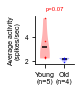

In [301]:
########################################################################
##### Figure 4j #####
########################################################################
plt.figure(figsize=[1.8, 2.2])
titles2 = ['Young', 'Old']
for condition in range(1):
    ax = plt.axes([0.7, 0.65- 0.65*condition, 0.3, 0.3])
    set_plot(ax)
    colors=['red', 'blue']
    nSample = []
    for i in [0,1]:
        inds = np.arange(N) if i==0 else np.arange(N, MeanSig.shape[0], 1)
        vp = plt.violinplot(MeanSig[inds], [i], showmeans=True, showextrema=False, widths=0.5)

        for pc in vp['bodies']:
            pc.set_facecolor(colors[i])
        vp['cmeans'].set_color('black')
        plt.plot(i*np.ones(len(inds)), MeanSig[inds], '.', color=colors[i], markersize=1)
        nSample.append(len(inds))
    plt.xlim([-0.5, 1.5])
    plt.xticks([0, 1], labels=[f'Young\n(n={nSample[0]})', f'Old\n(n={nSample[1]})'], fontsize=7)
    plt.ylabel(f'Average activity\n(spikes/sec)', fontsize=7)
    x = MeanSig[:N]
    y = MeanSig[N:]
    r, p = stats.ranksums(x,y)
    print(r,p)
    r, p = stats.ttest_ind(x,y)
    print(r,p)
    stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
    n1 = len(x)
    n2 = len(y)
    rank = n1*(n1+1)/2
    print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")

    plt.title(f'p={p:1.2f}', fontsize=6, color='red')
plt.savefig('JEDI_AbsFR.svg')

## Figure 4h left
c-Fos quantification

[2837.9538583  2904.46931539 2243.21964683 2734.97968894] [3939.83838035 1903.19031903 3432.49427918 4271.76830433]
W = 14.000, n1 = 4, n2 = 4, uncorrected p = 0.312
[1822.02267548 2028.60276657 1375.78505647 1831.11175756] [2305.05984971  840.2090209  1728.29844127 2402.05816505]
W = 17.000, n1 = 4, n2 = 4, uncorrected p = 0.885
[0.64201984 0.6984418  0.61330822 0.66951567] [0.58506457 0.44147399 0.50351095 0.56231003]
W = 26.000, n1 = 4, n2 = 4, uncorrected p = 0.030


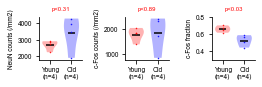

In [304]:
old = np.array([[1042, 739], [611,773], [1219, 1202], [1295, 1008]])
young=np.array([[1424, 794], [1524, 658], [977, 616], [1410, 696]])
area_young = np.array([781549, 751256, 710140, 770024])/1000000
area_old = np.array([452049, 727200, 705318, 539121])/1000000

set_rcParams()
plt.figure(figsize=[3, 0.6])
y_labels = ['NeuN counts (/mm2)','c-Fos counts (/mm2)', 'c-Fos fraction']

for i in range(3):
    if i==0:
        x = (young[:,0]+young[:,1])/area_young
        y = (old[:,0]+old[:,1])/area_old
        print(x, y)
    elif i==1:
        x = young[:,0]/area_young
        y = old[:,0]/area_old
        print(x, y)
    elif i==2:
        x = young[:,0]/(young[:,0]+young[:,1])
        y = old[:,0]/ (old[:,0]+old[:,1])
        print(x, y)
    
    axe = plt.axes([0.4*i,0, 0.2, 1])
    set_plot(axe)
    vp = plt.violinplot(x, [0], showmeans=True, showextrema=False, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor('red')
    vp['cmeans'].set_color('black')
    vp = plt.violinplot(y, [1], showmeans=True, showextrema=False, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor('blue')
    vp['cmeans'].set_color('black')
    plt.plot(0*np.ones(len(young)), x, '.', color='red', markersize=1)
    plt.plot(np.ones(len(old)), y, '.', color='blue', markersize=1)
    plt.xlim([-0.5, 1.5])
    plt.xticks(range(2), labels=[f'Young\n(n={len(x)})', f'Old\n(n={len(y)})'])
    plt.ylabel(y_labels[i])
    if i==2:
        plt.ylim([0.3, 0.8])

    r, p = stats.ranksums(x, y)
    stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')       
    n1 = len(x)
    n2 = len(y)
    rank = n1*(n1+1)/2
    print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
    plt.title(f'p={p:1.2f}', fontsize=6, color='red')

plt.savefig('BaselineIHC.svg')

## Figure 4h right
c-Fos quantification

[857.2719049  782.68925639 622.41248205 754.52193698] [1019.80095078  606.43564356  745.76290411 1103.6483461 ]
W = 17.000, n1 = 4, n2 = 4, uncorrected p = 0.885
0.8852339144732015
[569.38208609 519.13062924 277.41008815 441.54467913] [575.15888764 211.77117712 317.58724434 582.42954736]
W = 17.000, n1 = 4, n2 = 4, uncorrected p = 0.885
0.8852339144732015
[0.6641791  0.66326531 0.44570136 0.58519793] [0.56399132 0.34920635 0.42585551 0.52773109]
W = 24.000, n1 = 4, n2 = 4, uncorrected p = 0.112
0.11235119769046385


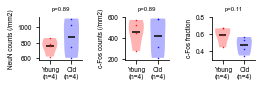

In [305]:
import numpy as np
import matplotlib.pyplot as plt

old = np.array([[260,201], [154,287], [224, 302], [314, 281]])
young=np.array([[445,225], [390, 198], [197, 245], [340, 241]])
area_young = np.array([781549, 751256, 710140, 770024])/1000000
area_old = np.array([452049, 727200, 705318, 539121])/1000000

set_rcParams()
plt.figure(figsize=[3, 0.6])
y_labels = ['NeuN counts (/mm2)','c-Fos counts (/mm2)', 'c-Fos fraction']

for i in range(3):
    if i==0:
        x = (young[:,0]+young[:,1])/area_young
        y = (old[:,0]+old[:,1])/area_old
        print(x, y)
    elif i==1:
        x = young[:,0]/area_young
        y = old[:,0]/area_old
        print(x, y)
    elif i==2:
        x = young[:,0]/(young[:,0]+young[:,1])
        y = old[:,0]/ (old[:,0]+old[:,1])
        print(x, y)
    
    axe = plt.axes([0.4*i,0, 0.2, 1])
    set_plot(axe)
    vp = plt.violinplot(x, [0], showmeans=True, showextrema=False, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor('red')
    vp['cmeans'].set_color('black')
    vp = plt.violinplot(y, [1], showmeans=True, showextrema=False, widths=0.7)
    for pc in vp['bodies']:
        pc.set_facecolor('blue')
    vp['cmeans'].set_color('black')
    plt.plot(0*np.ones(len(young)), x, '.', color='red', markersize=1)
    plt.plot(np.ones(len(old)), y, '.', color='blue', markersize=1)
    plt.xlim([-0.5, 1.5])
    plt.xticks(range(2), labels=[f'Young\n(n={len(x)})', f'Old\n(n={len(y)})'])
    plt.ylabel(y_labels[i])
    if i==2:
        plt.ylim([0.3, 0.8])

    r, p = stats.ranksums(x, y)
    stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
    n1 = len(x)
    n2 = len(y)
    rank = n1*(n1+1)/2
    print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
    plt.title(f'p={p:1.2f}', fontsize=6, color='black')
    print(p)

plt.savefig('BaselineIHC_L23.svg')

# Figure 5 and Supplementary Figure 4-5
This block includes cells that compile mouse information from optogenetic experiment, process and plot data.

## Load subject database for optogenetic experiment

In [286]:
##### Load subject database and compile mice from control and optogenetic experiments

SubjectDB = np.load('2025Nature_SubjectDB.npy', allow_pickle = True).item()

group_criteria = [
    combine_criteria(2, 3,   ['experiment', 'genotype'], ['Control', 'WT']),
    combine_criteria(15, 25, ['experiment', 'genotype'], ['Control', 'WT']),
    combine_criteria(15, 25, ['experiment', 'genotype'], ['STIM', 'WT']),
    combine_criteria(15, 25, ['experiment', 'genotype'], ['INACT', 'WT']),
] 
subjectsOpto, Opto_group_names, Opto_ages, Opto_sexes, Opto_dates = group_subjects(group_criteria, SubjectDB)

### ITI distribution of optogenetic experiment

In [56]:
##### Opto trial ITI distribution
all_time = np.array(Get_timeInfo(subjectsOpto[2:], MaxDay=16))
bigmat=[]
ti=1 #0 for session duration, 1 for iti length
for at in all_time:
    bigmat = at[:,:,ti] if len(bigmat)==0 else np.concatenate((bigmat, at[:,:,ti]), axis=0)
print('Mean ITI, SD ITI, min ITI, max ITI')
print(np.nanmean(bigmat),np.nanstd(bigmat), np.nanmin(bigmat), np.nanmax(bigmat))

Mean ITI, SD ITI, min ITI, max ITI
4.323024430108584 0.7377452016298052 2.847572818181871 8.079492898148139


## Figure 5c
Early exploration comparison

Kruskal-Wallis H-test: H = 15.157, p = 0.002

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 213.000, n1 = 12, n2 = 12, uncorrected p = 0.000
Group 1 vs Group 3: W = 121.000, n1 = 12, n2 = 7, uncorrected p = 0.966
Group 1 vs Group 4: W = 145.500, n1 = 12, n2 = 7, uncorrected p = 0.034
Group 2 vs Group 3: W = 91.000, n1 = 12, n2 = 7, uncorrected p = 0.016
Group 2 vs Group 4: W = 127.000, n1 = 12, n2 = 7, uncorrected p = 0.583
Group 3 vs Group 4: W = 68.000, n1 = 7, n2 = 7, uncorrected p = 0.055

corrected p-values:
Group 1 vs Group 2: corrected p = 0.002
Group 1 vs Group 3: corrected p = 0.966
Group 1 vs Group 4: corrected p = 0.069
Group 2 vs Group 3: corrected p = 0.048
Group 2 vs Group 4: corrected p = 0.699
Group 3 vs Group 4: corrected p = 0.083


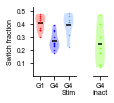

In [287]:
########################################################################
##### Figure 5c #####
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch3(sessions[:3], opto=2)

        if not np.isnan(fraction):
            fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
    axi.set_ylim(0, 0.53)
    axi.set_yticks(np.arange(0.1,0.6,0.1))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)

    axi.set_ylabel('Switch fraction', fontsize=7)

plt.savefig('Opto_explore.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Supplementary Figure 4
Early exploration comparison

Kruskal-Wallis H-test: H = 14.011, p = 0.003

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 208.000, n1 = 12, n2 = 12, uncorrected p = 0.001
Group 1 vs Group 3: W = 110.000, n1 = 12, n2 = 7, uncorrected p = 0.422
Group 1 vs Group 4: W = 144.000, n1 = 12, n2 = 7, uncorrected p = 0.047
Group 2 vs Group 3: W = 90.000, n1 = 12, n2 = 7, uncorrected p = 0.013
Group 2 vs Group 4: W = 125.500, n1 = 12, n2 = 7, uncorrected p = 0.671
Group 3 vs Group 4: W = 68.000, n1 = 7, n2 = 7, uncorrected p = 0.055

corrected p-values:
Group 1 vs Group 2: corrected p = 0.005
Group 1 vs Group 3: corrected p = 0.506
Group 1 vs Group 4: corrected p = 0.083
Group 2 vs Group 3: corrected p = 0.038
Group 2 vs Group 4: corrected p = 0.671
Group 3 vs Group 4: corrected p = 0.083
Kruskal-Wallis H-test: H = 12.674, p = 0.005

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 207.500, n1 = 12, n2 = 12, uncorrected p = 0.001
Group 1 vs Group 3: W = 124.000, n1 = 12, n2 = 7, uncorrected p = 0.767
Group 1 vs

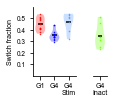

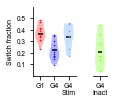

In [291]:
########################################################################
##### Supplementary Figure 4 #####
##### Win switch random exploration
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch1(sessions[:3], opto=2)

        if not np.isnan(fraction):
            fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
    axi.set_ylim(0, 0.6)
    axi.set_yticks(np.arange(0.1,0.6,0.1))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)

    axi.set_ylabel('Switch fraction', fontsize=7)

plt.savefig('Opto_win_switch.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

########################################################################
##### Lose switch directed exploration
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch2(sessions[:3], opto=2)

        if not np.isnan(fraction):
            fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize = 1)
    axi.set_ylim(0, 0.6)
    axi.set_yticks(np.arange(0.1,0.6,0.1))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)

    axi.set_ylabel('Switch fraction', fontsize=7)

plt.savefig('Opto_lose_switch.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 5d
Reaction time comparison

Kruskal-Wallis H-test: H = 15.799, p = 0.001

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 97.000, n1 = 12, n2 = 12, uncorrected p = 0.002
Group 1 vs Group 3: W = 115.000, n1 = 12, n2 = 7, uncorrected p = 0.704
Group 1 vs Group 4: W = 88.000, n1 = 12, n2 = 7, uncorrected p = 0.008
Group 2 vs Group 3: W = 148.000, n1 = 12, n2 = 7, uncorrected p = 0.020
Group 2 vs Group 4: W = 106.000, n1 = 12, n2 = 7, uncorrected p = 0.254
Group 3 vs Group 4: W = 32.000, n1 = 7, n2 = 7, uncorrected p = 0.011

corrected p-values:
Group 1 vs Group 2: corrected p = 0.015
Group 1 vs Group 3: corrected p = 0.704
Group 1 vs Group 4: corrected p = 0.021
Group 2 vs Group 3: corrected p = 0.030
Group 2 vs Group 4: corrected p = 0.305
Group 3 vs Group 4: corrected p = 0.021


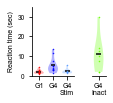

In [288]:
########################################################################
##### Figure 5d #####
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        RT, NT =Compute_otherParams(sessions[:3], numTR=200, opto=2)       
        fraction = RT
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
    axi.set_ylim(0, 35)
#    axi.set_yticks(np.arange(0.3,0.9,0.2))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)
    axi.set_ylabel('Reaction time (sec)', fontsize=7)
plt.savefig('Opto_RT.svg')

groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 5e
Number of trials comparison

331.69444444444446
189.3611111111111
291.6190476190476
132.04761904761904
Kruskal-Wallis H-test: H = 22.710, p = 0.000

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 214.000, n1 = 12, n2 = 12, uncorrected p = 0.000
Group 1 vs Group 3: W = 135.000, n1 = 12, n2 = 7, uncorrected p = 0.220
Group 1 vs Group 4: W = 160.000, n1 = 12, n2 = 7, uncorrected p = 0.001
Group 2 vs Group 3: W = 88.500, n1 = 12, n2 = 7, uncorrected p = 0.009
Group 2 vs Group 4: W = 136.000, n1 = 12, n2 = 7, uncorrected p = 0.190
Group 3 vs Group 4: W = 75.000, n1 = 7, n2 = 7, uncorrected p = 0.005

corrected p-values:
Group 1 vs Group 2: corrected p = 0.001
Group 1 vs Group 3: corrected p = 0.220
Group 1 vs Group 4: corrected p = 0.003
Group 2 vs Group 3: corrected p = 0.013
Group 2 vs Group 4: corrected p = 0.220
Group 3 vs Group 4: corrected p = 0.010


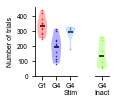

In [289]:
########################################################################
##### Figure 5e #####
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        RT, NT =Compute_otherParams(sessions[:3], numTR=200, opto=2)       
        fraction = NT
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    #print(fractions)
    Frac.append(fractions)
    print(np.nanmean(fractions, axis=0))
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
    axi.set_ylim(0, 460)
#    axi.set_yticks(np.arange(0.3,0.9,0.2))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)        
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)

    axi.set_ylabel('Number of trials', fontsize=7)
plt.savefig('Opto_NT.svg')


groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Supplementary Figure 5 left
Light on verus off exploration

ShapiroResult(statistic=0.8740904927253723, pvalue=0.20148219168186188)
-0.5331544636993933 0.6130873379584854 7


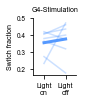

In [325]:
########################################################################
##### Supplementary Figure 3 left #####
########################################################################
subjects_stim = [subjectsOpto[2], subjectsOpto[2]]

set_rcParams()
plt.figure(figsize=np.array([0.6,0.8]))
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1 = ['#5599FF', '#5599FF']
labels = [f'Light\non', f'Light\noff']
inds2 = [1, 0]
Frac =[]
for i, subject_list in enumerate(subjects_stim): 
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        fraction = FractionSwitch3(sessions[:3], opto=inds2[i])

        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
Frac=np.array(Frac)
plt.plot(Frac, color='#5599FF', alpha=0.3)
plt.plot(np.mean(Frac,axis=1), color='#5599FF', linewidth=3)

plt.xlim(-0.5, 1.5)
plt.yticks(np.arange(0.2, 0.51, 0.1))
plt.ylabel('Switch fraction', fontsize=7)
plt.title('G4-Stimulation', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)

x = Frac[0]
y = Frac[1]
# r, p = stats.wilcoxon(x,y)
# print(r,p)
# stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
# n1 = len(x)
# n2 = len(y)
# rank = n1*(n1+1)/2
# print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
print(stats.shapiro(x-y))
r, p= stats.ttest_rel(x, y)
print(r, p, len(x))

plt.savefig('Opto_OnVOff.svg')

## Supplementary Figure 5 right
Light on verus off reaction time

2.193462539440605
2.068885443907188
ShapiroResult(statistic=0.8502681851387024, pvalue=0.12359689176082611)
0.36524645394253946 0.7274572590434875 7


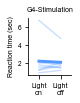

In [323]:
########################################################################
##### Supplementary Figure 3 right #####
########################################################################

subjects_stim = [subjectsOpto[2], subjectsOpto[2]]

set_rcParams()
plt.figure(figsize=np.array([0.6,0.8]))
axe = plt.axes([0,0,1,1])
set_plot(axe)

colors1 = ['#5599FF', '#5599FF']
labels = [f'Light\non', f'Light\noff']
inds2 = [1, 0]
Frac =[]
for i, subject_list in enumerate(subjects_stim): 
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        RT, NT =Compute_otherParams(sessions[:3], numTR=200, opto=inds2[i])
        fraction = RT

        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    print(np.nanmean(fractions, axis=0))
Frac=np.array(Frac)
plt.plot(Frac, color='#5599FF', alpha=0.3)
plt.plot(np.mean(Frac,axis=1), color='#5599FF', linewidth=3)

plt.xlim(-0.5, 1.5)
#plt.yticks(np.arange(0.2, 0.51, 0.1))
plt.ylabel('Reaction time (sec)', fontsize=7)
plt.title('G4-Stimulation', fontsize=7)
plt.xticks(range(len(labels)), labels, fontsize=7)

x = Frac[0]
y = Frac[1]
# r, p = stats.wilcoxon(x,y)
# print(r,p)
# stat, p = stats.mannwhitneyu(x, y, alternative='two-sided')        
# n1 = len(x)
# n2 = len(y)
# rank = n1*(n1+1)/2
# print(f"W = {stat + rank:.3f}, n1 = {n1:.0f}, n2 = {n2:.0f}, uncorrected p = {p:.3f}")
print(stats.shapiro(x-y))
r, p= stats.ttest_rel(x, y)
print(r, p, len(x))


plt.savefig('Opto_OnVOffRT.svg')

## Figure 5f
Learning curves from optogenetic experiment

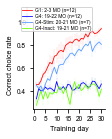

In [62]:
########################################################################
##### Figure 5f #####
########################################################################
colors1 = ['red', 'blue', '#5599FF', '#66FF00']
allOpto=PlotMean(subject_lists=subjectsOpto, colors = colors1, ylims=[0.25,1], 
             legends=['G1: 2-3 MO ', 'G4: 19-22 MO ', 'G4-Stim: 20-21 MO ','G4-Inact: 19-21 MO '], figscale=0.16)
plt.savefig("OptoLearningCurve.svg")

## Figure 5g
Learning comparison of optogenetic mice

Kruskal-Wallis H-test: H = 29.414, p = 0.000

Pairwise Mann–Whitney U tests:
Group 1 vs Group 2: W = 222.000, n1 = 12, n2 = 12, uncorrected p = 0.000
Group 1 vs Group 3: W = 149.000, n1 = 12, n2 = 7, uncorrected p = 0.016
Group 1 vs Group 4: W = 162.000, n1 = 12, n2 = 7, uncorrected p = 0.000
Group 2 vs Group 3: W = 79.000, n1 = 12, n2 = 7, uncorrected p = 0.001
Group 2 vs Group 4: W = 138.000, n1 = 12, n2 = 7, uncorrected p = 0.139
Group 3 vs Group 4: W = 76.000, n1 = 7, n2 = 7, uncorrected p = 0.003

corrected p-values:
Group 1 vs Group 2: corrected p = 0.000
Group 1 vs Group 3: corrected p = 0.019
Group 1 vs Group 4: corrected p = 0.001
Group 2 vs Group 3: corrected p = 0.001
Group 2 vs Group 4: corrected p = 0.139
Group 3 vs Group 4: corrected p = 0.005


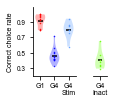

In [295]:
########################################################################
##### Figure 5g #####
########################################################################

set_rcParams()
fig = plt.figure(figsize=np.array([1.6,1.2])*0.8)
ax0 = plt.axes((0,0, 0.46,1))
ax1 = plt.axes((0.65,0, 0.15,1))
set_plot(ax0)
set_plot(ax1)

colors1 = ['red', 'blue', '#5599FF', '#66FF00']
Frac =[]
for i, subject_list in enumerate(subjectsOpto): 
    axi = ax0 if i<3 else ax1
    fractions = np.array([])
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld',qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        y = FullContrastPerf(sessions) 
        if len(y)>25:
            learning = np.nanmean(y[25:30])
        else:
            learning = np.nanmean(y[-5:])
        fraction = learning
        
        if not np.isnan(fraction):
            fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
    Frac.append(fractions)
    vp = axi.violinplot(fractions, [i], showmeans=True, showextrema=False, widths=0.7)
    
    for pc in vp['bodies']:
        pc.set_facecolor(colors1[i])
    vp['cmeans'].set_color('black')
    axi.plot(i*np.ones(fractions.shape[0]), fractions, '.', color=colors1[i], markersize=1)
    axi.set_ylim(0.2, 1.1)
    axi.set_yticks(np.arange(0.3,0.9,0.2))
    if i==2:
        axi.set_xticks([0,1,2])
        axi.set_xticklabels(['G1', 'G4', f'G4\nStim'], fontsize=7)
        axi.set_xlim(-0.5, 2.5)
    elif i==3:
        axi.set_xticks([3])
        axi.set_xticklabels([f'G4\nInact'], fontsize=7)
        axi.set_xlim(2.5, 3.5)
        axi.yaxis.set_visible(False)
        axi.spines['left'].set_visible(False)
    axi.set_ylabel('Correct choice rate', fontsize=7)


plt.savefig('Opto_learning.svg')


groups = {
    "Group 1": Frac[0],
    "Group 2": Frac[1],
    "Group 3": Frac[2],
    "Group 4": Frac[3]
}
postHoc_mutipleComparisons(groups, method='fdr_bh')

## Figure 5h
Exploration versus Learning in old mice

0.651489615554662 0.021724735067411623
0.18018749253911182 0.6990457740939315
0.6785714285714287 0.0937502539598313
0.6627907364351273 0.00022462751133662826 26


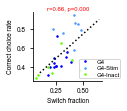

In [306]:
########################################################################
##### Figure 5h #####
########################################################################

set_rcParams()
plt.figure(figsize=np.array([1.2,1.2])*0.8)
axe = plt.axes([0,0,1,1])
set_plot(axe)

labels =['G1','G2','G3','G4']
inds = [0, 0, 0, 0]
colors1=['blue',  '#5599FF', '#66FF00']
Frac = []
PerfMat = []

for i, subject_list in enumerate(subjectsOpto[1:]): 

    fractions = np.array([])
    Perf = []
    for subject in subject_list:
        sessions = sorted(one.alyx.rest('sessions','list',subject=subject, task_protocol='ChoiceWorld', qc='CRITICAL', no_cache=True), key=lambda d:d['start_time'])
        
        fraction = FractionSwitch3(sessions[:3], opto=2)
        fractions = np.hstack((fractions, fraction)) if fractions.size else fraction
        
        y = FullContrastPerf(sessions)
        if len(y)>25:
            learning = np.nanmean(y[25:30])
        else:
            learning = np.nanmean(y[-5:])
        Perf.append(learning)
    Perf = np.array(Perf)
    if len(Perf)>0:
        ind = np.flatnonzero(~(np.isnan(Perf)))
        xf =fractions
        r,p = stats.spearmanr(xf[ind], Perf[ind])        
        print(r,p)
        if len(Frac)==0:
            Frac = fractions
            PerfMat = np.array(Perf)
        else:
            Frac = np.concatenate((Frac,fractions))
            PerfMat = np.concatenate((PerfMat,np.array(Perf)))
        x = fractions
        y = Perf
        plt.plot(x, y, '.', color=colors1[i], alpha=1, markersize=3)

plt.legend(['G4', 'G4-Stim', 'G4-Inact'], fontsize=6, loc='lower right', bbox_to_anchor=(1.3, 0), borderpad=0.1, labelspacing=0.2)
ind = np.flatnonzero(~(np.isnan(PerfMat)))
x = Frac[ind]
y = PerfMat[ind]
r,p = stats.spearmanr(x, y)
print(r,p, len(x))
res = stats.linregress(x, y)
x2 = np.arange(0.1, 0.7, 0.05)
plt.plot(x2, res.intercept + res.slope*x2, 'k:')

plt.xlabel('Switch fraction')
plt.ylabel('Correct choice rate')
plt.title(f'r={r:1.2f}, p={p:1.3f}', fontsize=6, color='r', pad=0.2)
plt.savefig('ExploreLearningCorr_Opto.svg')

## Human to mouse age
Based on Cottam et al, JN 2025

[2.4642393801516715, 4.651832151382571, 6.702170653538145, 10.792554129303745, 20.640332026751196]


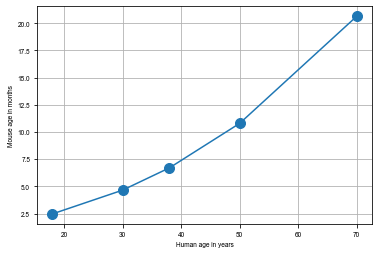

In [330]:
def human2mouse(human_age_in_years):
    x = np.log10(human_age_in_years)
    y = -1.1289 + 0.1667*x - 0.183*np.power(x,2) + 0.1471*np.power(x,3) + 0.121*np.power(x,4) - 0.0068*np.power(x,5) - 0.0127*np.power(x,6)
    mouse_age_in_months = np.power(10,y)*12
    return mouse_age_in_months
X = [18, 30, 38, 50, 70]
Y = []
for x in X:
    Y.append(human2mouse(x))
print(Y)
plt.plot(X, Y, '.-', markersize=20)
plt.xlabel('Human age in years')
plt.ylabel('Mouse age in months')
plt.grid('on')